In [114]:
import pandas as pd 
import numpy as np # linear algebra
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport as PR
%matplotlib inline

# Work package 1

In this work package, the purpose is to preprocess the data, and select the relervant features for developing a classification model. There are a few tasks in this work package:
* Task 1: Cleaning. In this task, the aim is to clean the data by removing/imputating the missing values and outliers. 
* Task 2: Preprocessing. The aim of this task is to encode the categorical features and combine them with the numerical features. Also, we need to scale the numerical features.
* Task 3: Feature selection. The aim of this task is to decide which features are relervant and needs to be used in the classification model to be developed.

In this section, you need to present the following (with code and texts to explain):
1. Data preprocessing: How do you clean and preprocess the data.
2.  Feature engineering: What are the features you selected and how do you select them.

## Reading the data.

The original data are stored in an excel file. In the supporting script utility.py, we provide you with a supproting function read_data, which can read the origial data and tranform it into a DataFrame for easy use.

In [115]:
from utility import read_data

file_name = 'Excel - Jeu de données 30min.xlsx'
df_data_org = read_data(file_name)

test


In [116]:
df_data_org.head(10)

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,Label,Speed
0,0.095028,0.108673,0.124450,0.028452,0.103652,0.840367,0.000235,0.002229,0.004425,0.019680,0.152843,0.289421,0,100
1,0.114830,0.116392,0.119189,0.022256,0.065612,0.318523,0.002731,0.003595,0.006944,0.187470,0.245774,0.472644,0,100
2,0.115623,0.116716,0.118186,0.020222,0.038325,0.295456,0.002918,0.003596,0.006187,0.197608,0.245268,0.424281,0,100
3,0.116281,0.118019,0.119925,0.020494,0.021857,0.024859,0.002772,0.003589,0.005595,0.187848,0.242001,0.376719,0,100
4,0.117399,0.119179,0.121064,0.018967,0.031151,0.116402,0.002744,0.003860,0.014931,0.185445,0.257477,0.981690,0,100
5,0.117801,0.120088,0.121385,0.019339,0.021165,0.023875,0.002446,0.003696,0.007134,0.162313,0.244888,0.470853,0,100
6,0.119973,0.121245,0.122769,0.018367,0.020098,0.025943,0.002446,0.003975,0.008013,0.162313,0.260925,0.523719,0,100
7,0.120086,0.121471,0.123690,0.017371,0.020301,0.025252,0.002654,0.004439,0.028653,0.175149,0.290388,1.850730,0,100
8,0.121960,0.125248,0.135252,0.020031,0.021623,0.024422,0.003321,0.012901,0.100119,0.213721,0.804334,5.951260,0,100
9,0.121968,0.128777,0.140647,0.018936,0.073434,0.716553,0.003154,0.029169,0.101640,0.205839,1.772610,5.752400,0,100


In [117]:
print(df_data_org.size)
print(df_data_org.shape)

2520
(180, 14)


We can print the first 10 rows of the dataset. We can see that:
* The first 12 columns are the features collected from sensor.
* Label: 0 - Not failure, 1 - Failure.
* Speed: Rotation speed.

We can visualize the data, by drawing the time series of each feature, under each speed condition and failure state.

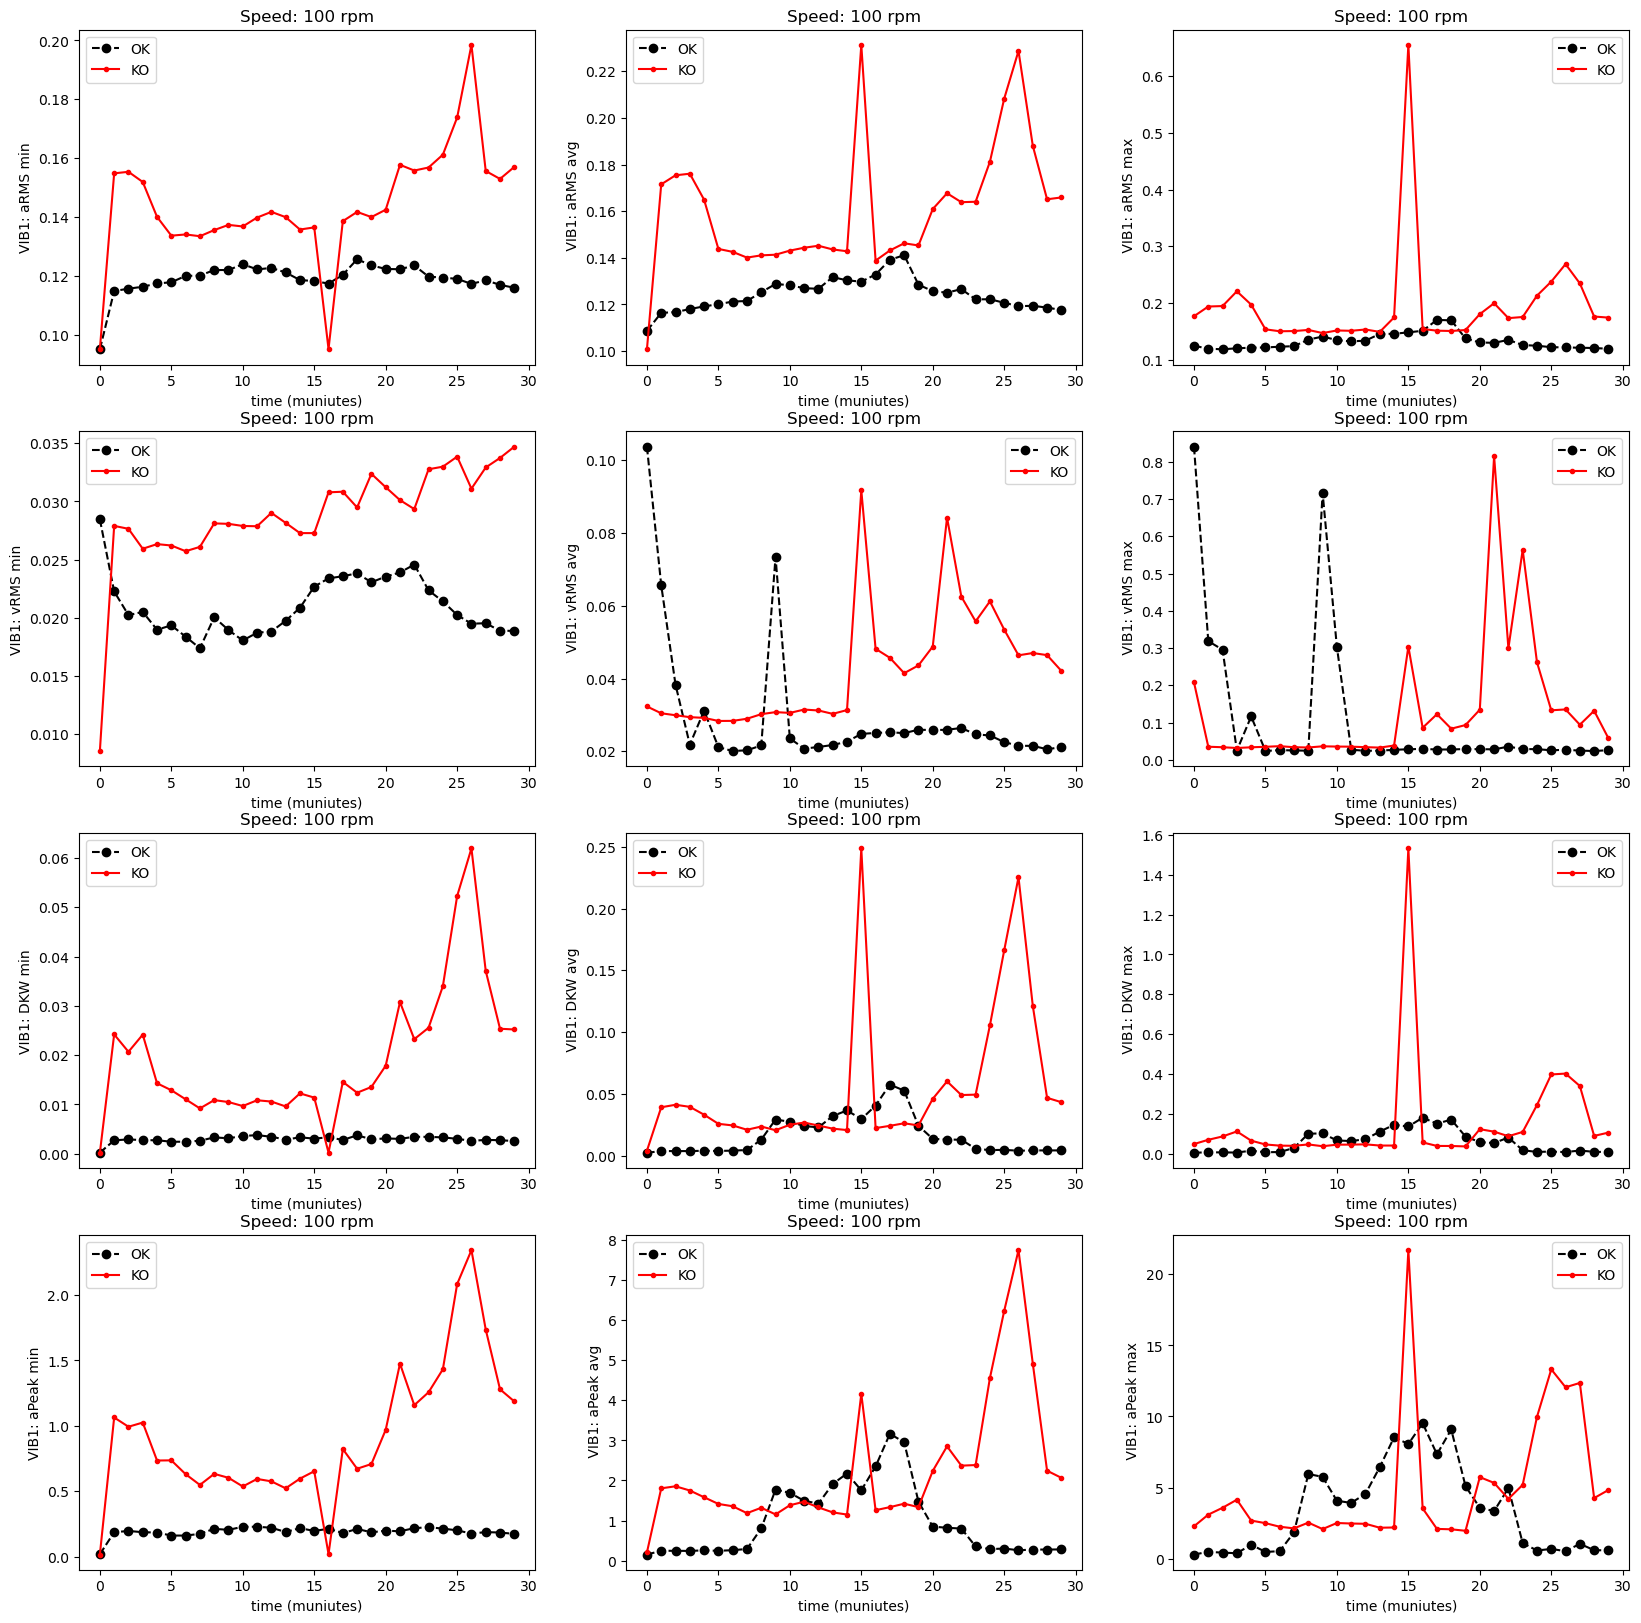

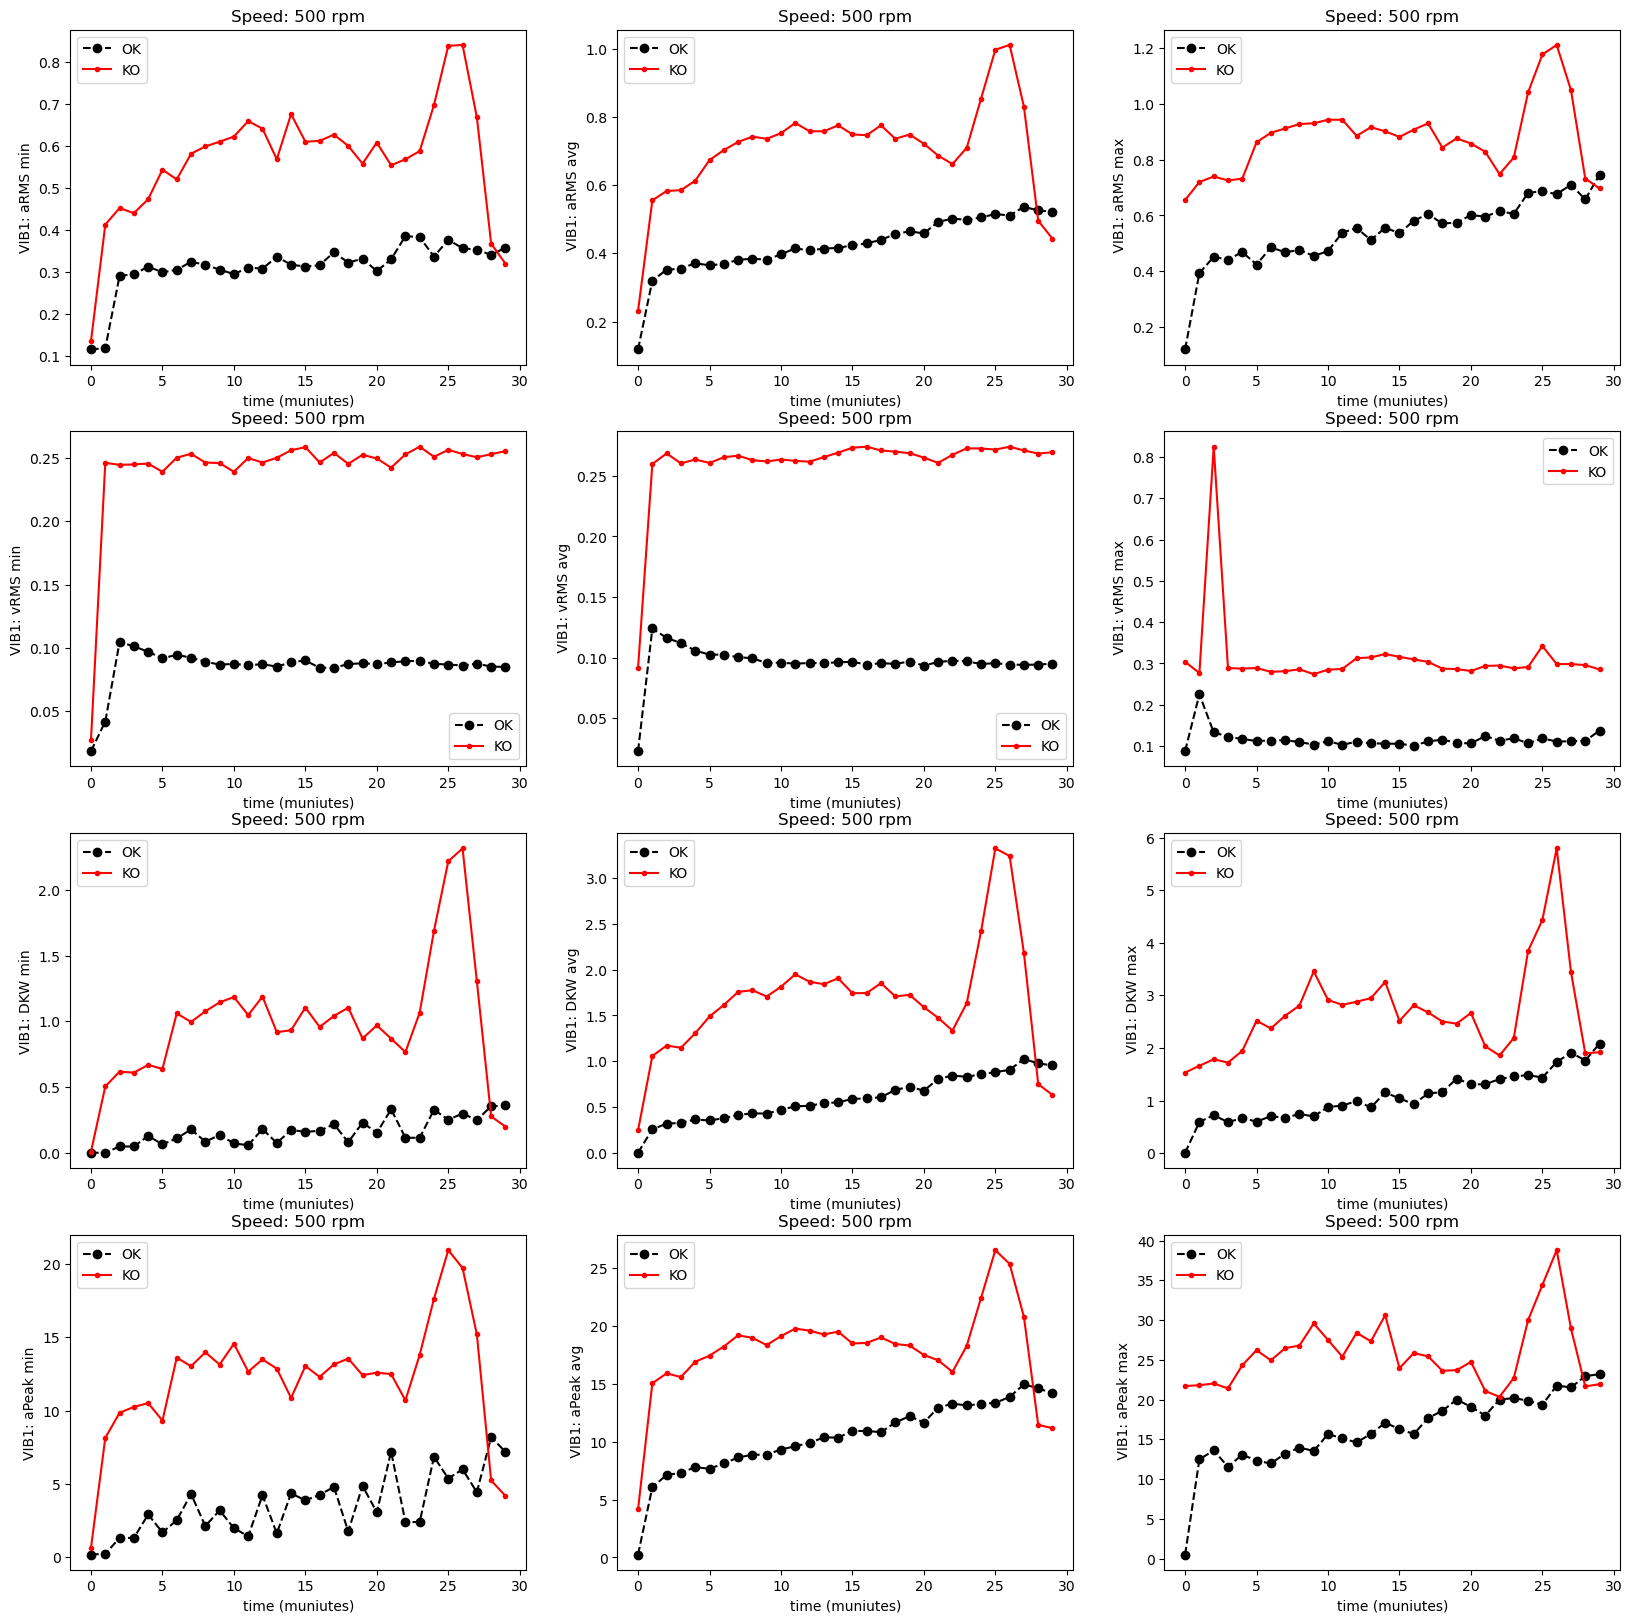

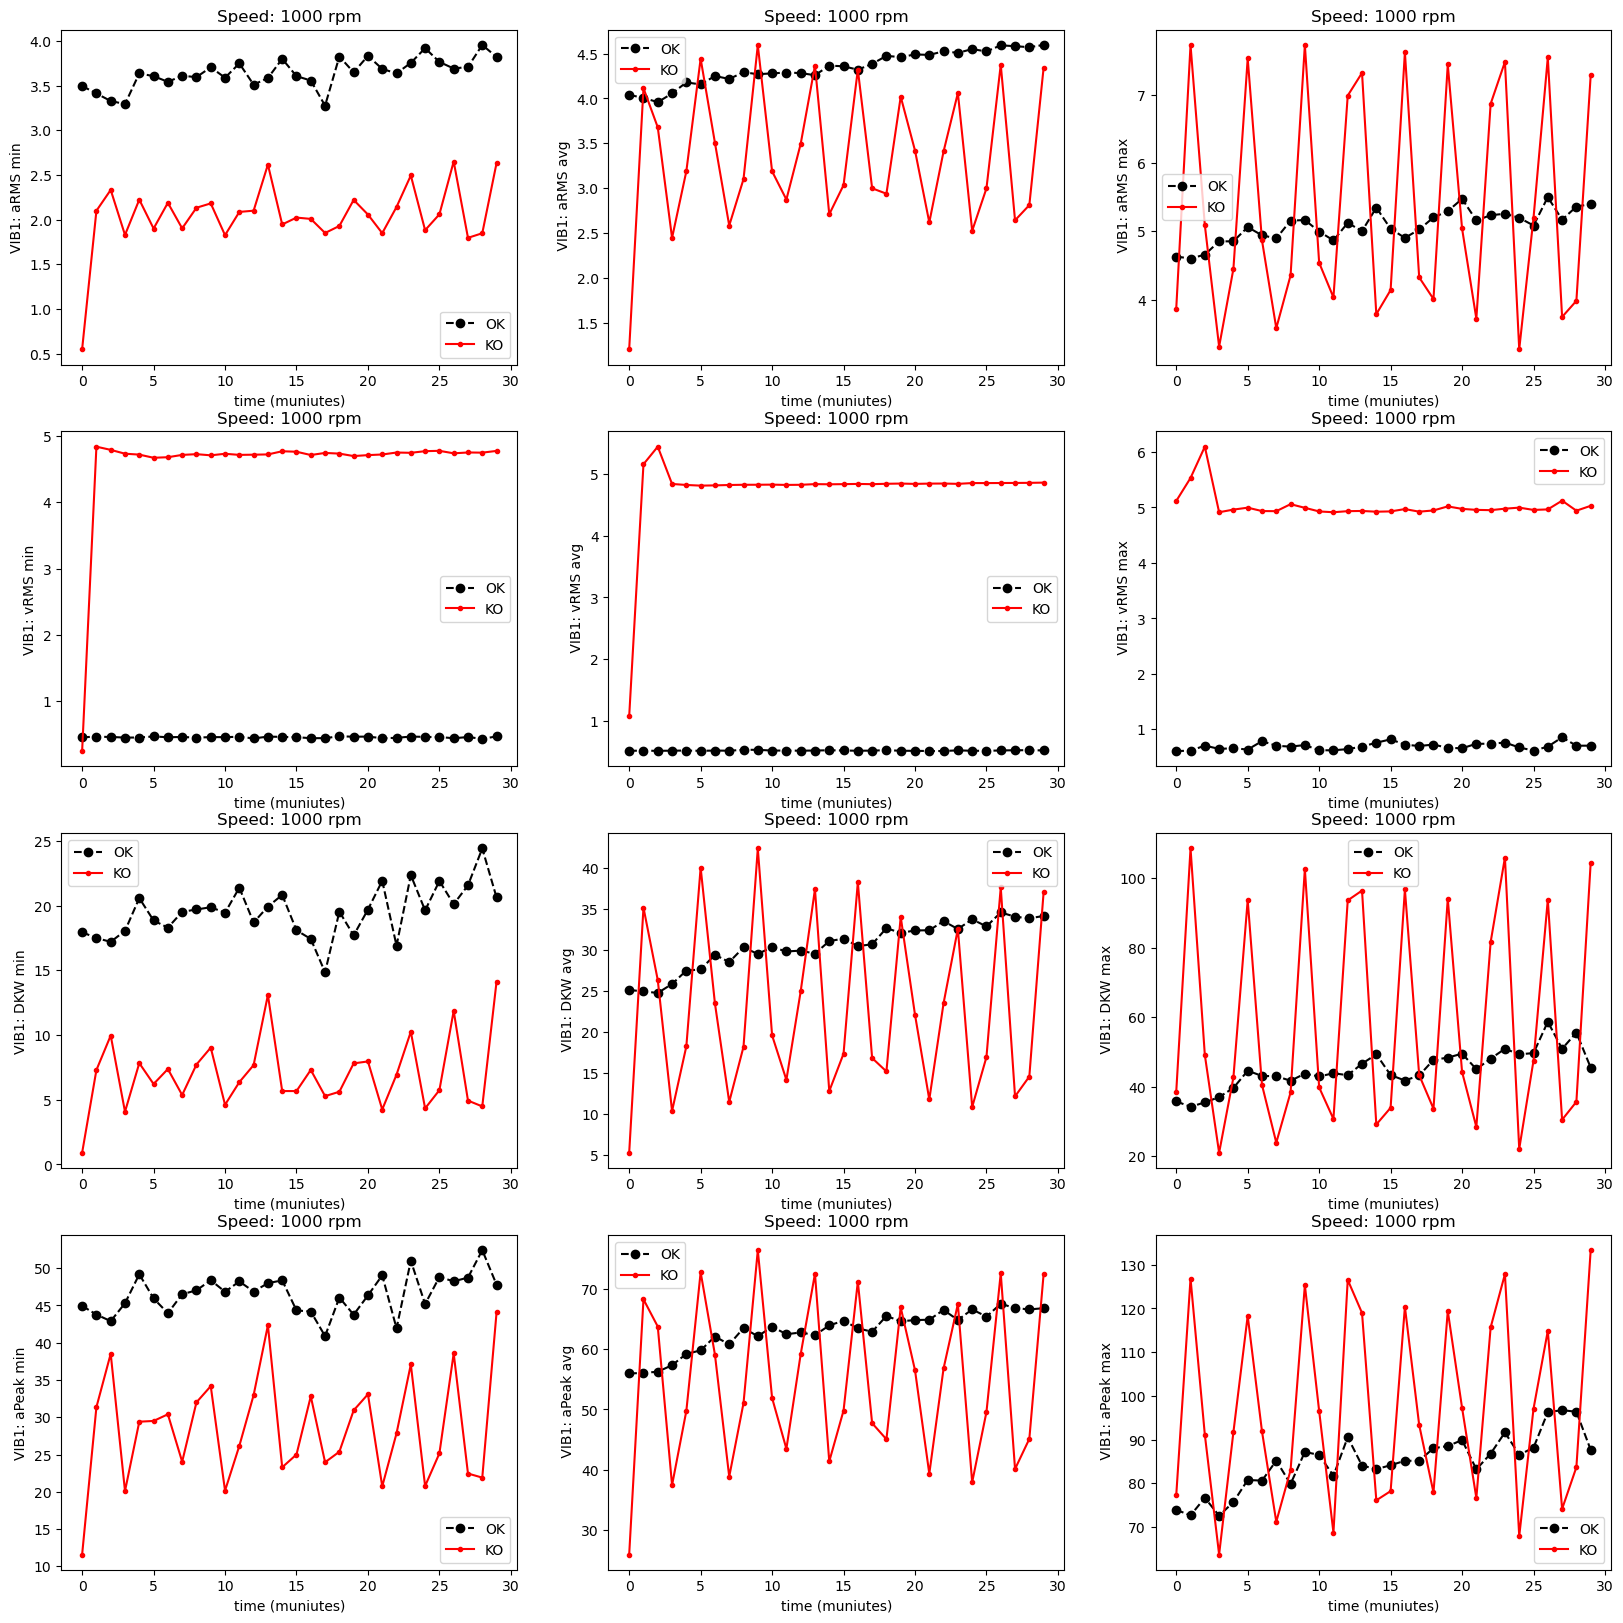

In [118]:
import numpy as np
import matplotlib.pyplot as plt

for speed in [100, 500, 1000]:
    fig, ax = plt.subplots(4, 3, figsize=(20, 20))
    i, j = 0, 0
    for feature in df_data_org.columns[:12]:
        ax[i,j].plot(np.arange(30), df_data_org[(df_data_org['Label']==0) & (df_data_org['Speed']==speed)][feature], '--ko', 
            np.arange(30), df_data_org[(df_data_org['Label']==1) & (df_data_org['Speed']==speed)][feature], '-r.')
        ax[i,j].set_xlabel('time (muniutes)')
        ax[i,j].set_ylabel(feature)
        ax[i,j].set_title('Speed: {} rpm'.format(speed))
        ax[i,j].legend(['OK', 'KO'])

        j+=1
        if j==3:
            i+=1
            j=0

## Task 1: Cleaning

First of all, in order to clean the data, with the given code we verified that there were no empty values. Then we considered the outliers for each feature of each sensor, if there were any values extraordinary normal from the other ones they were either errased or given a value proximate to the rest. 

### Missing values
When we have the original data, we often start by checking if the dataset contain some missing values. If so, we could either remove them, or replace them with some selected values (like means, mode, etc). For a tutorial, you can find it here: https://colab.research.google.com/drive/18eOdS_fTbM7gOzuRfZWHZ_2OqTTf6a1z

We use the isnull() function to check for missing values. For a reference, see here: https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/

You can see from the results, we are lucky to have no missing values in our dataset.

In [119]:
df_data_org.isnull().values.any()

False

### Outlier

The next step is to define a method to remove the potential outliers in the numerical features. As we discussed in the video class, an easy way to detect outlier is through statistical approaches: Fit a statistical distribution to all the data, then, the data point which exceed a upper or lower quartitile will be regarded as outlier. If we fit a normal distribution, then, this leads to the so-called Z-score approach: https://www.analyticsvidhya.com/blog/2022/08/dealing-with-outliers-using-the-z-score-method/.

After identifying the outlier, you also need to choose your strategy to handle them. You can simply remove them, but you will lose some information because maybe only one feature is affected by the outlier. An alternative approach is to treat this outlier as a missing value, and fill it with some pre-selected numbers (e.g., the mean of the feature): https://colab.research.google.com/drive/18eOdS_fTbM7gOzuRfZWHZ_2OqTTf6a1z


In [120]:
# Get the features and labels.
X_org = df_data_org.iloc[:, :12]
y = df_data_org['Label']

In [121]:
def handle_outlier(x):
    ul = x.mean() + 3*x.std()
    ll = x.mean() - 3*x.std()
    x[(x>ul) | (x<ll)] = x.mean()

    return x

X = X_org.copy(deep=True)
df_data = df_data_org.copy(deep=True)
for speed in [100, 500, 1000]:
    for label in [0, 1]:    
        for col in X_org.columns:
            x = X.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed), col]
            x = handle_outlier(x)
            X.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed), col] = x
            df_data.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed), col] = x

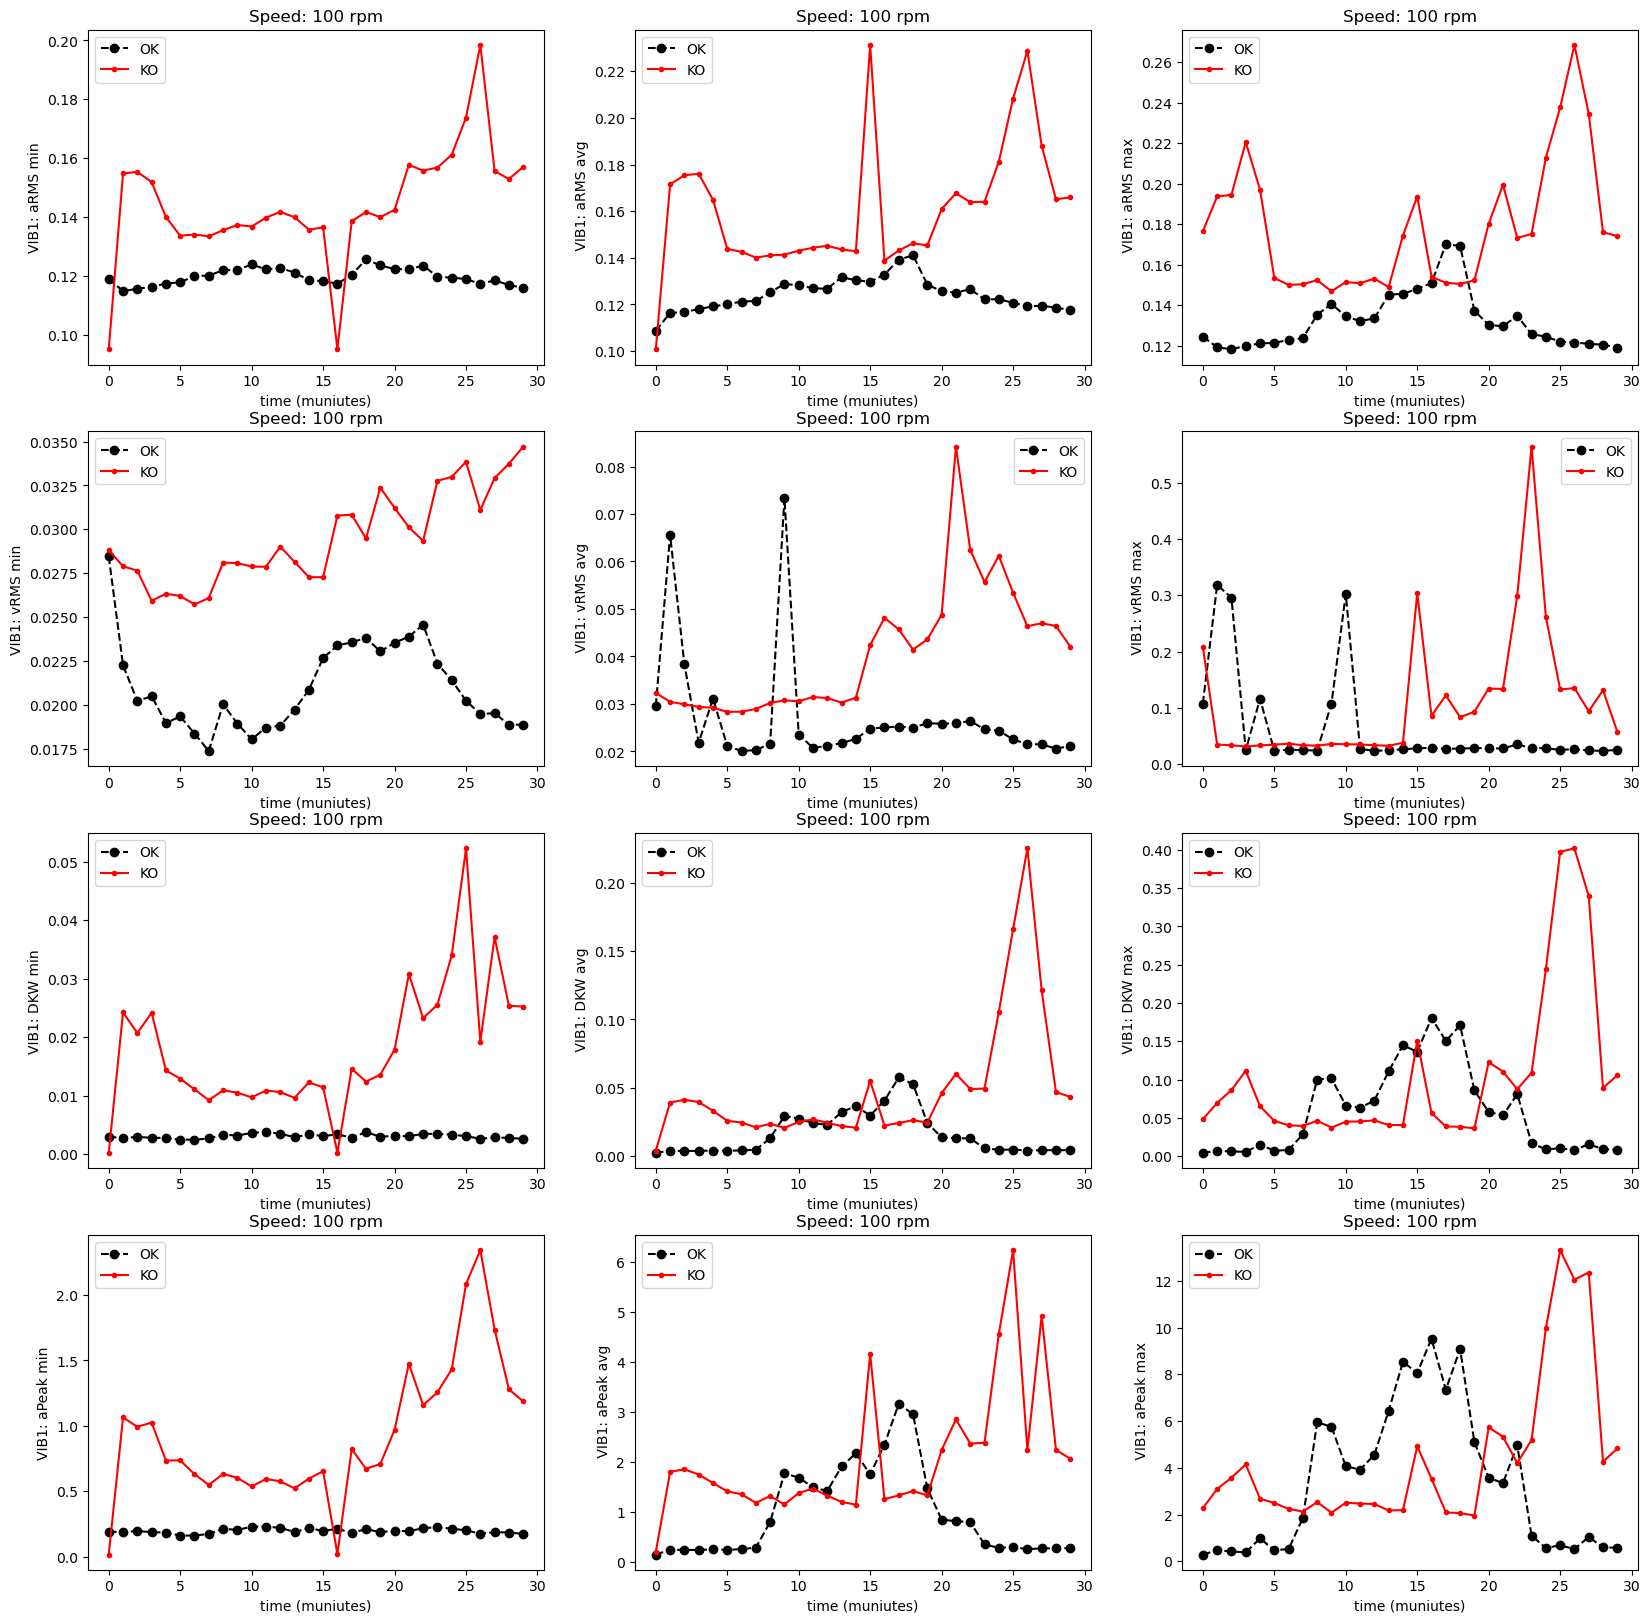

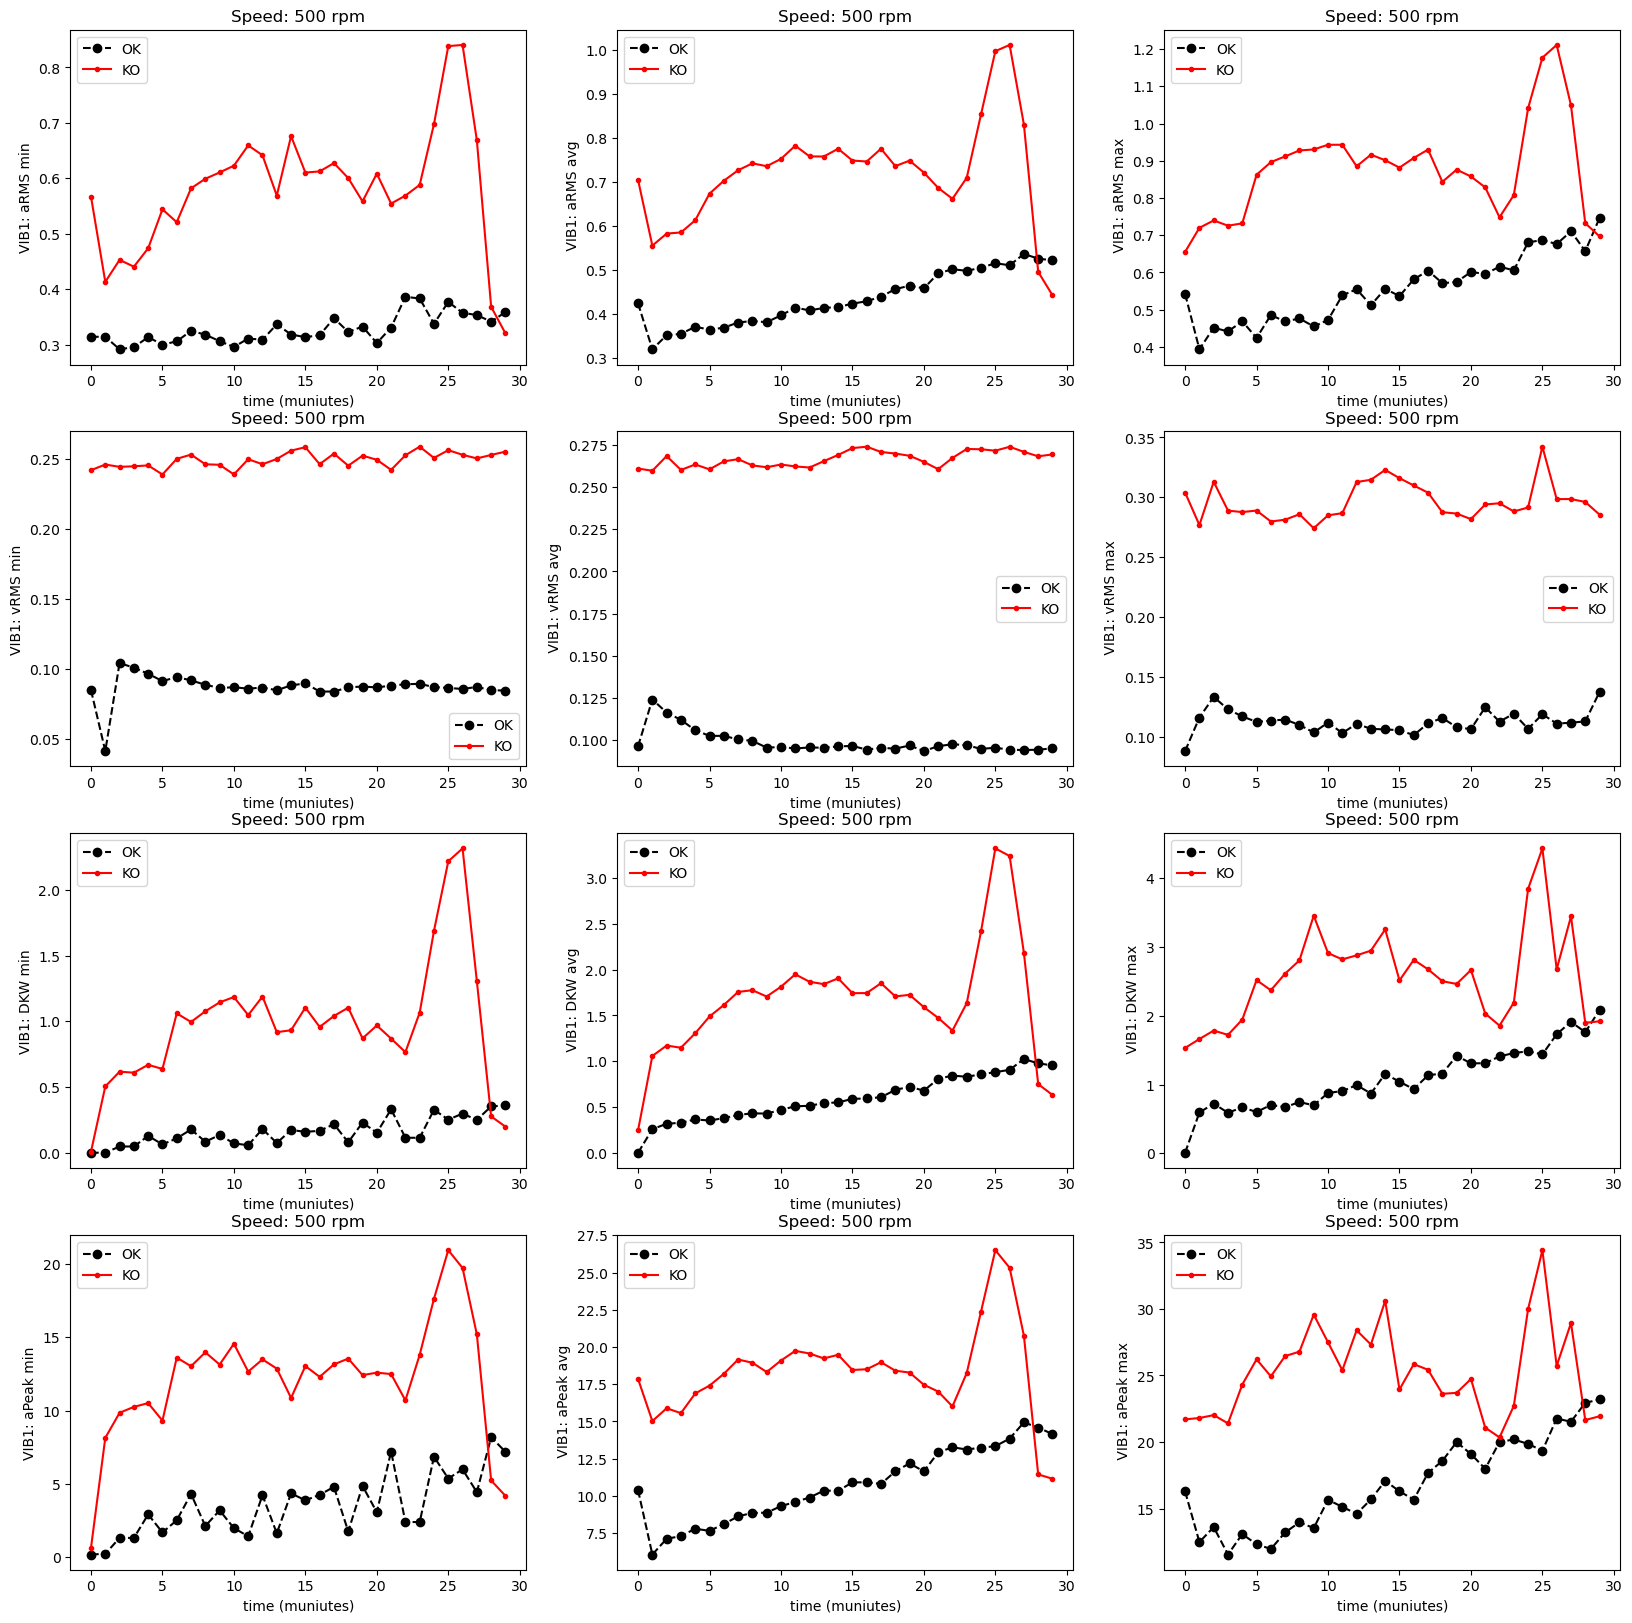

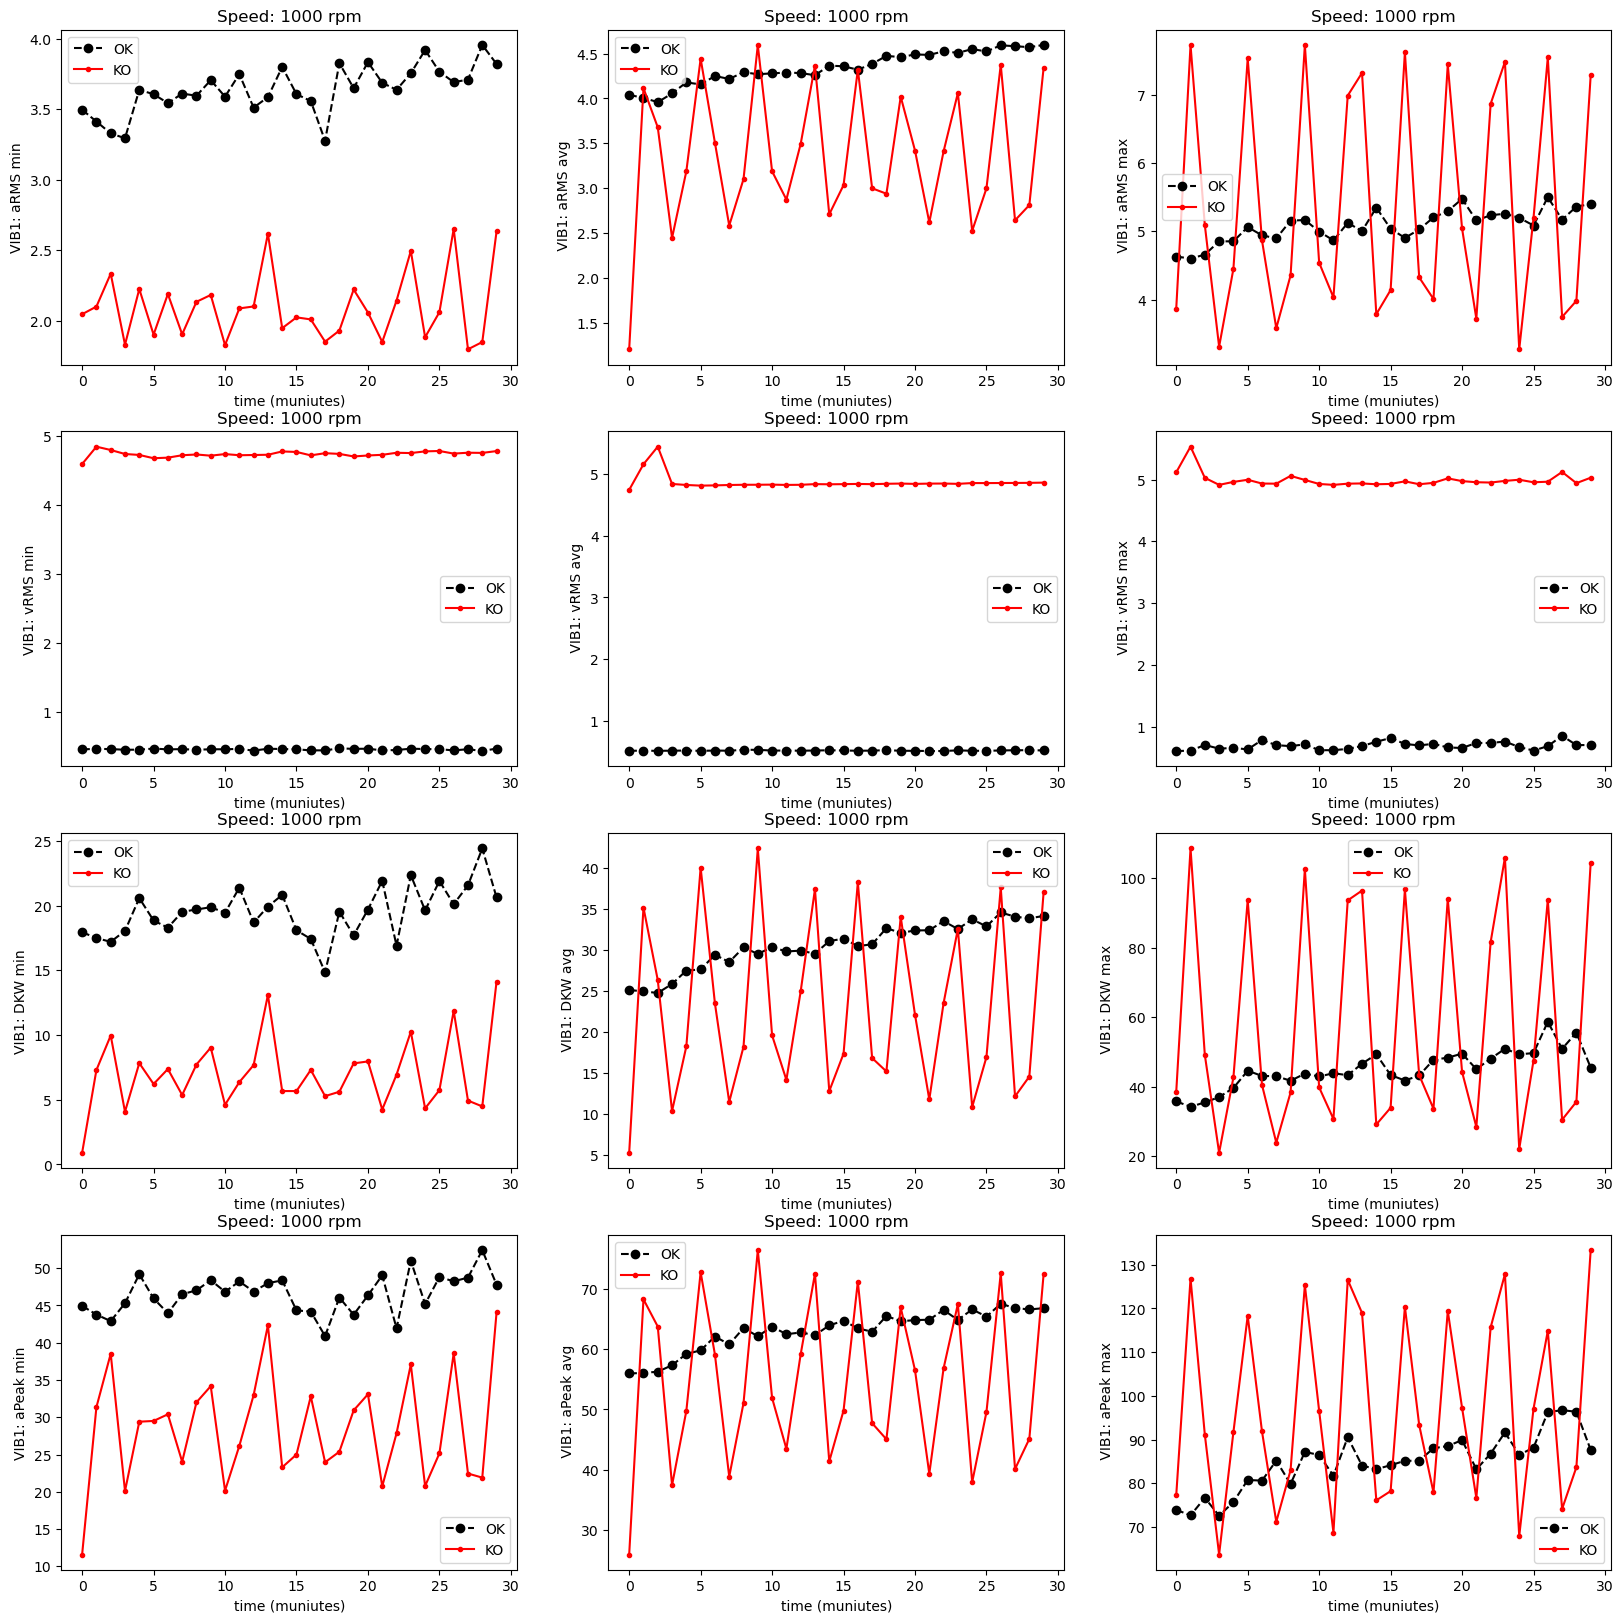

In [122]:
for speed in [100, 500, 1000]:
    fig, ax = plt.subplots(4, 3, figsize=(20, 20))
    i, j = 0, 0
    for feature in df_data_org.columns[:12]:
        ax[i,j].plot(np.arange(30), X[(df_data_org['Label']==0) & (df_data_org['Speed']==speed)][feature], '--ko', 
            np.arange(30), X[(df_data_org['Label']==1) & (df_data_org['Speed']==speed)][feature], '-r.')
        ax[i,j].set_xlabel('time (muniutes)')
        ax[i,j].set_ylabel(feature)
        ax[i,j].set_title('Speed: {} rpm'.format(speed))
        ax[i,j].legend(['OK', 'KO'])

        j+=1
        if j==3:
            i+=1
            j=0

## Task 2 : Preprocessing

In this step, we scaled the features, so that we can avoid that features with naturally big numbers overshadow features with smaller numbers.
We also encode speed, in fact, there are only 3 values of speed : 100, 500, 1000. and depending of the values, the vibrations change greatly, therefore, we treat speed as a categorical feature

In [123]:
from sklearn import preprocessing

# Get the features and the labels.
Speed = df_data['Speed'].copy(deep= True)
X = df_data.drop(['Label'], axis=1)
Speed_encoded = pd.get_dummies(Speed, drop_first=True)
y = df_data['Label']
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = pd.DataFrame(data=scaler.transform(X), columns=X.columns)
X = pd.concat([X, Speed_encoded], axis=1)
X = X.rename(columns={500:'500', 1000:'1000'})
X.head(10)

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,Speed,500,1000
0,-0.789312,-0.825551,-0.804636,-0.527634,-0.536658,-0.526689,-0.636545,-0.697604,-0.651478,-0.869620,-0.974956,-0.981062,-1.176965,0,0
1,-0.792483,-0.821033,-0.806857,-0.531264,-0.516094,-0.408313,-0.636576,-0.697501,-0.651386,-0.869888,-0.971297,-0.976368,-1.176965,0,0
2,-0.791877,-0.820844,-0.807280,-0.532455,-0.531674,-0.421275,-0.636550,-0.697501,-0.651414,-0.869304,-0.971317,-0.977607,-1.176965,0,0
3,-0.791374,-0.820081,-0.806546,-0.532295,-0.541076,-0.573326,-0.636570,-0.697502,-0.651436,-0.869866,-0.971445,-0.978826,-1.176965,0,0
4,-0.790518,-0.819402,-0.806066,-0.533190,-0.535770,-0.521887,-0.636574,-0.697481,-0.651095,-0.870005,-0.970836,-0.963326,-1.176965,0,0
5,-0.790211,-0.818870,-0.805930,-0.532972,-0.541471,-0.573879,-0.636615,-0.697493,-0.651379,-0.871336,-0.971332,-0.976414,-1.176965,0,0
6,-0.788549,-0.818193,-0.805346,-0.533541,-0.542081,-0.572717,-0.636615,-0.697472,-0.651347,-0.871336,-0.970700,-0.975059,-1.176965,0,0
7,-0.788463,-0.818061,-0.804957,-0.534125,-0.541964,-0.573106,-0.636586,-0.697437,-0.650593,-0.870597,-0.969540,-0.941060,-1.176965,0,0
8,-0.787030,-0.815850,-0.800076,-0.532567,-0.541210,-0.573572,-0.636494,-0.696800,-0.647983,-0.868377,-0.949303,-0.836000,-1.176965,0,0
9,-0.787023,-0.813785,-0.797799,-0.533208,-0.511629,-0.526689,-0.636517,-0.695576,-0.647928,-0.868831,-0.911175,-0.841095,-1.176965,0,0


## Task 3: Feature selection

### PCA to have a look at the data patterns.

   principal component 1  principal component 2  Label
0              -2.809869               0.111030      0
1              -2.777777               0.175360      0
2              -2.784371               0.160694      0
3              -2.819949               0.084062      0
4              -2.802102               0.110818      0
[0.79746856 0.15613313]


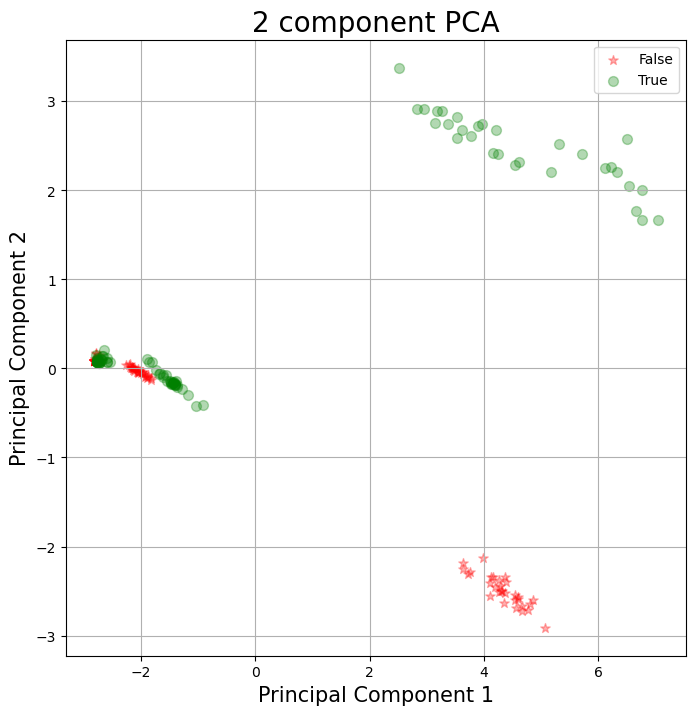

In [124]:
from utility import data_visualization_2d_pca

data_visualization_2d_pca(X, y, feature_list=X.columns)

We can see that using PCA, we can discored to components that separate a consequent part of the data. However, the other part is not separable.

### Feature selection


#### Visual examination of the significance of the features.

A quick and easy way to examine if the features are relevant is to check $p(feature|label).$ If the conditional distribution of a feature changes a lot given positive/negative labels, we could suspect that it is a feature with significant impact. Otherwise, we might assume that this feature does not affect the result a lot.

For continuous features, we usually use volin plot. Here we show a demonstration how to construct a violin plot. You can try on the other continuous features to explore which features are highly significant. Please use it to determine the features you want to keep.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'VIB1: aRMS min'),
  Text(1, 0, ' VIB1: aRMS avg'),
  Text(2, 0, ' VIB1: aRMS max'),
  Text(3, 0, 'VIB1: vRMS min'),
  Text(4, 0, ' VIB1: vRMS avg'),
  Text(5, 0, ' VIB1: vRMS max')])

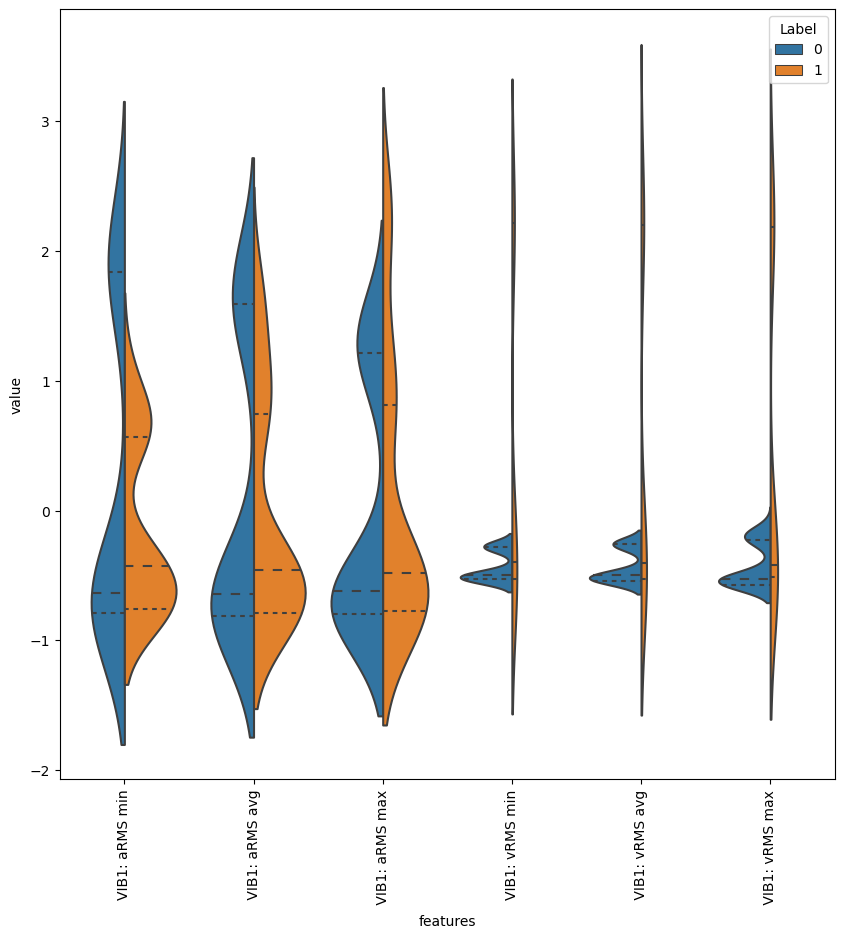

In [125]:
# first ten features
x = X.iloc[:, :6]

data = pd.concat([y, x], axis=1)
data = pd.melt(data,id_vars='Label',
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue='Label', data=data, split=True, inner="quart")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'VIB1: DKW min'),
  Text(1, 0, ' VIB1: DKW avg'),
  Text(2, 0, ' VIB1: DKW max'),
  Text(3, 0, 'VIB1: aPeak min'),
  Text(4, 0, ' VIB1: aPeak avg'),
  Text(5, 0, ' VIB1: aPeak max'),
  Text(6, 0, 'Speed')])

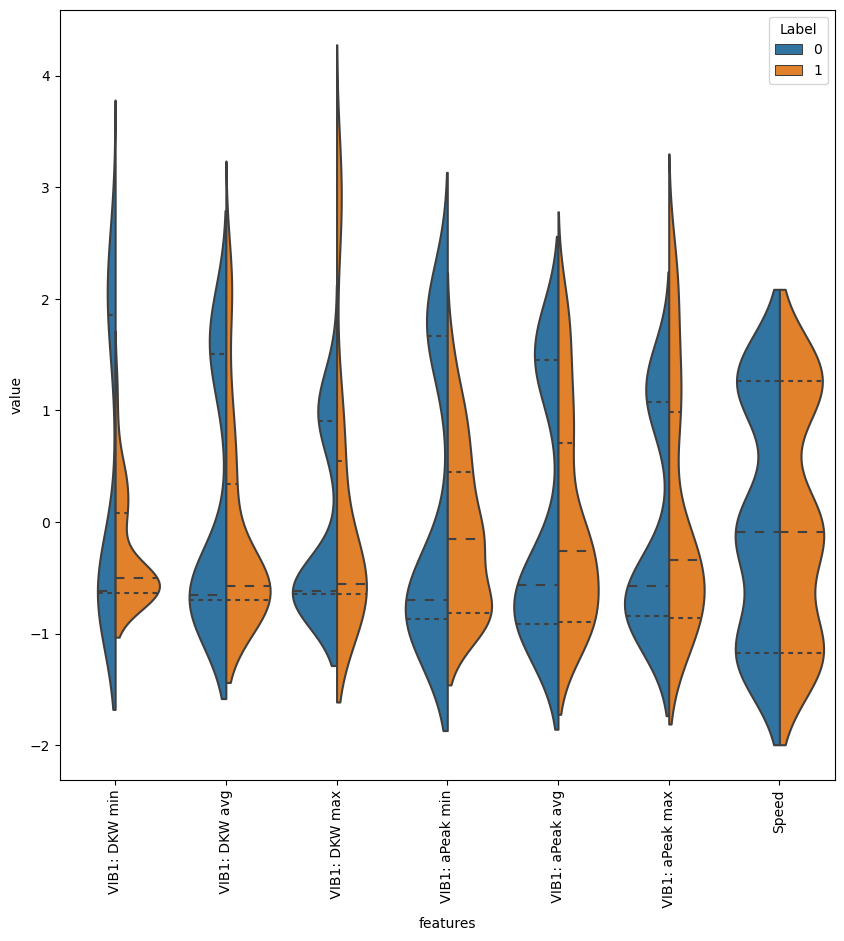

In [126]:
# first ten features
x = X.iloc[:, 6:13]

data = pd.concat([y, x], axis=1)
data = pd.melt(data,id_vars='Label',
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue='Label', data=data, split=True, inner="quart")
plt.xticks(rotation=90)

#### Box plot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'VIB1: aRMS min'),
  Text(1, 0, ' VIB1: aRMS avg'),
  Text(2, 0, ' VIB1: aRMS max'),
  Text(3, 0, 'VIB1: vRMS min'),
  Text(4, 0, ' VIB1: vRMS avg'),
  Text(5, 0, ' VIB1: vRMS max'),
  Text(6, 0, 'VIB1: DKW min'),
  Text(7, 0, ' VIB1: DKW avg'),
  Text(8, 0, ' VIB1: DKW max'),
  Text(9, 0, 'VIB1: aPeak min'),
  Text(10, 0, ' VIB1: aPeak avg'),
  Text(11, 0, ' VIB1: aPeak max'),
  Text(12, 0, 'Speed'),
  Text(13, 0, '500'),
  Text(14, 0, '1000')])

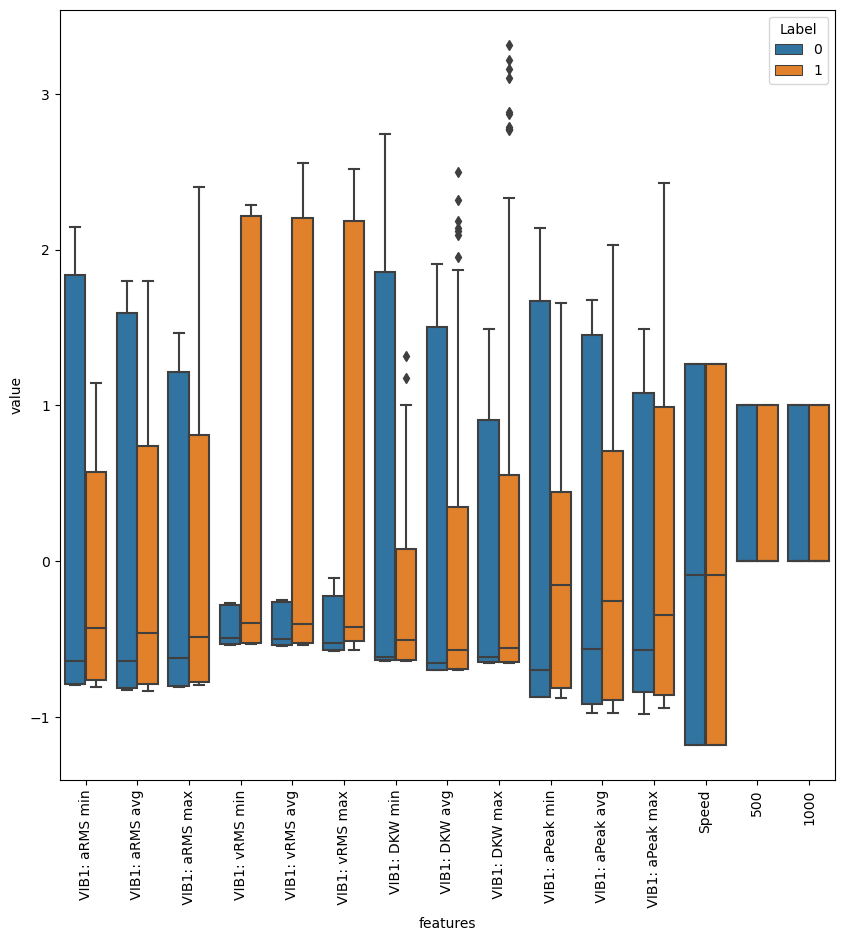

In [127]:
# 1st 10 features
data = pd.concat([y, X], axis=1)
data = pd.melt(data,id_vars='Label',
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="Label", data=data)
plt.xticks(rotation=90)

#### Correlation matrix.

For the numerical features, you can also try to identify the relervant features using correlation matrix. The idea is to keep only the features highly correlated to the labels. Also, if two features are correlated, usually we only need to keep one of them.

Reference: https://www.kaggle.com/code/zhiguozeng/feature-selection-and-data-visualization

<Axes: >

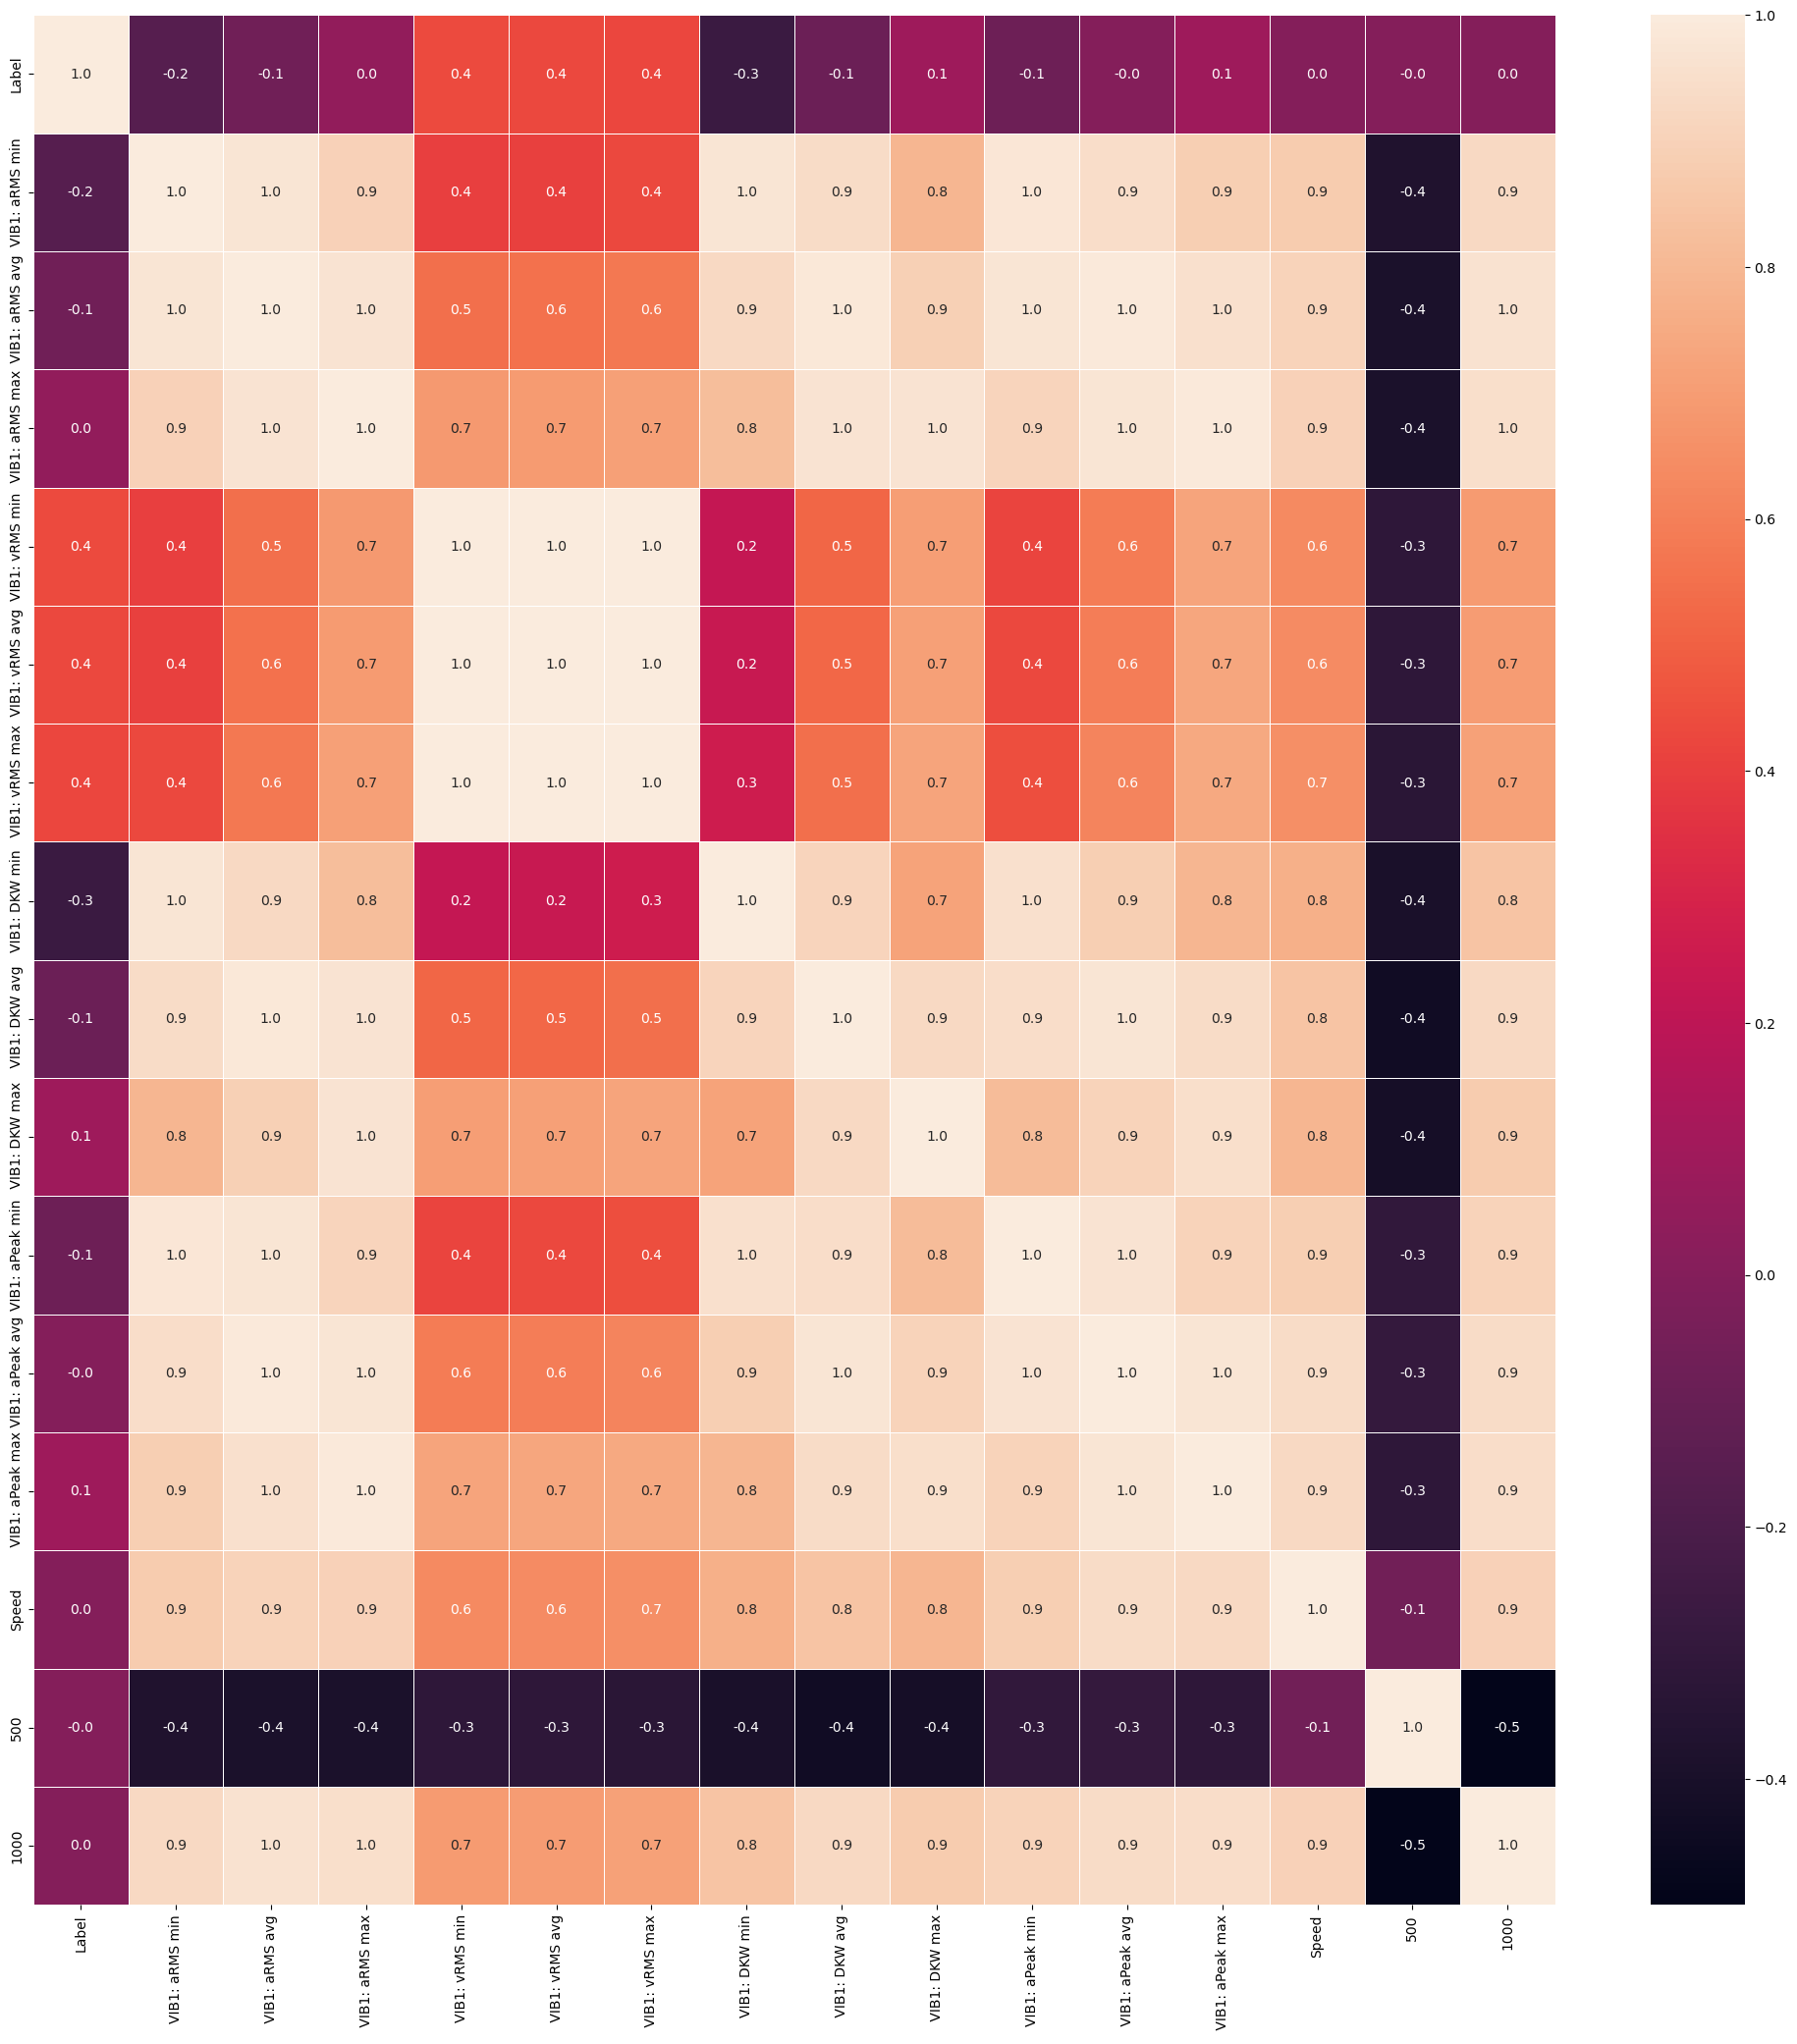

In [128]:
# correlation map
data = pd.concat([y, X], axis=1)
f,ax = plt.subplots(figsize=(25, 25))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Once you decide what are the relervant features, you can try the following code to verify your choice of the features by checking the performance of a Logistic regression model. We start with a simple classifier of logistic regression. Note that in the sample code, we only use the numerical feature. If you encode the categorical features, you should use all the features by replacing df_con to your new dataframe.

##### backup
Before doing anything, let's backup X that is already preprocessed, so we can choose any features and quickly revert it

In [129]:
X_backup = X.copy(deep=True)
X_backup.head(10)

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,Speed,500,1000
0,-0.789312,-0.825551,-0.804636,-0.527634,-0.536658,-0.526689,-0.636545,-0.697604,-0.651478,-0.869620,-0.974956,-0.981062,-1.176965,0,0
1,-0.792483,-0.821033,-0.806857,-0.531264,-0.516094,-0.408313,-0.636576,-0.697501,-0.651386,-0.869888,-0.971297,-0.976368,-1.176965,0,0
2,-0.791877,-0.820844,-0.807280,-0.532455,-0.531674,-0.421275,-0.636550,-0.697501,-0.651414,-0.869304,-0.971317,-0.977607,-1.176965,0,0
3,-0.791374,-0.820081,-0.806546,-0.532295,-0.541076,-0.573326,-0.636570,-0.697502,-0.651436,-0.869866,-0.971445,-0.978826,-1.176965,0,0
4,-0.790518,-0.819402,-0.806066,-0.533190,-0.535770,-0.521887,-0.636574,-0.697481,-0.651095,-0.870005,-0.970836,-0.963326,-1.176965,0,0
5,-0.790211,-0.818870,-0.805930,-0.532972,-0.541471,-0.573879,-0.636615,-0.697493,-0.651379,-0.871336,-0.971332,-0.976414,-1.176965,0,0
6,-0.788549,-0.818193,-0.805346,-0.533541,-0.542081,-0.572717,-0.636615,-0.697472,-0.651347,-0.871336,-0.970700,-0.975059,-1.176965,0,0
7,-0.788463,-0.818061,-0.804957,-0.534125,-0.541964,-0.573106,-0.636586,-0.697437,-0.650593,-0.870597,-0.969540,-0.941060,-1.176965,0,0
8,-0.787030,-0.815850,-0.800076,-0.532567,-0.541210,-0.573572,-0.636494,-0.696800,-0.647983,-0.868377,-0.949303,-0.836000,-1.176965,0,0
9,-0.787023,-0.813785,-0.797799,-0.533208,-0.511629,-0.526689,-0.636517,-0.695576,-0.647928,-0.868831,-0.911175,-0.841095,-1.176965,0,0


## Final output of workpackage 1

After inspecting the correlation matrix, we decided to only keep the average of each sensor and the encoded speed, the correlation inbetween these features are low and their correlation with the label is high. Also, each sensor's min and max values are correlated with the avergae.
Although the speed is not correlated with the label, we decided to keep it, because other features greatly change depending on speed. We can also think of building  three models that each handles one speed value 

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

X = X_backup.copy(deep=True)
# split data train 70 % and test 30 %
x_train_backup, x_test_backup, y_train, y_test = train_test_split(X, y, test_size=0.3)

After test several models, we decided to keep most of the features because in our case the execution time was not a problem, as the dataset is not big enough, and furthermore the model we are using does not have any problem or misperformance when given correlated features.
By trying the model with these caracteristics we obtained better results than when avoiding some, as there is more information to train.

In [131]:
id_to_keep = [0,1,2,3,4,5,6,7,8,9,10,11,13,14]
# id_to_keep = [1,4,7,10,13,14]

### checking the scores of selected features

we train a logistic regression on 70% of the training set, and use the remaining data to evalutate the score :
because the split is random, each time we rerun the notebook (when it is closed for example) the scores change, so we need to conduct the test at one time without closing the notebook.
score results demonstrated that this combination [0,3,4,5,7,9,10,13,14] gives solid results.

Accuracy is:  0.9259259259259259
Recall is:  0.8518518518518519
Precision is:  1.0
F1 is:  0.92


<Axes: >

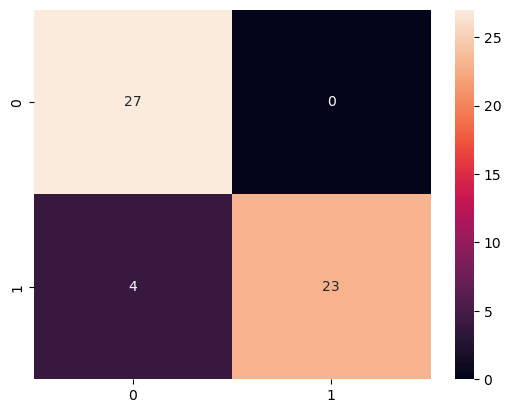

In [132]:

x_train = x_train_backup.iloc[:, id_to_keep]
x_test = x_test_backup.iloc[:, id_to_keep]

# Logistic regression
clf = LogisticRegression(penalty='l2', C=1)      
clr = clf.fit(x_train,y_train)

ac = accuracy_score(y_test, clf.predict(x_test))
print('Accuracy is: ',ac)
recall = recall_score(y_test, clf.predict(x_test))
print('Recall is: ',recall)
precision = precision_score(y_test, clf.predict(x_test))
print('Precision is: ', precision)
f1 = f1_score(y_test, clf.predict(x_test))
print('F1 is: ',f1)

cm = confusion_matrix(y_test, clf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

## Summary of preprocessing

### What if speed is missing

In the test excel, to pages do not have speed, so we need to find a way to handle this problem.
Seeing that speed impacts greatly the other sensors, we chose to train a model to predict the speed using the other features.
We try 2 models : Logistic regression and Random forest classifier (remember that we treat speed as a categorical feature)

#### Logistic regression

##### We train the model on 80% of the data, and we use the rest to evaluate the performance

Accuracy is:  1.0


<Axes: >

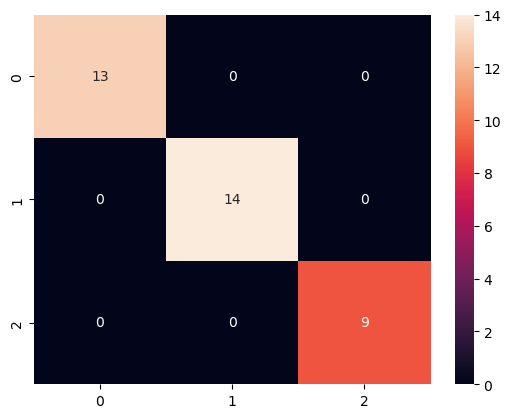

In [133]:
X = X_backup.copy(deep=True).iloc[:,:12]
X_train, X_test, Speed_train, Speed_test = train_test_split(X, Speed, test_size=0.2, random_state=42)
Speed_clf_1 = LogisticRegression()

Speed_clf_1 = LogisticRegression(penalty='l2', C=1)
Speed_clf_1 = Speed_clf_1.fit(X_train,Speed_train)
Speed_pred = Speed_clf_1.predict(X_test)
ac = accuracy_score(Speed_test, Speed_pred)
print('Accuracy is: ',ac)
# recall = recall_score(Speed_test, Speed_pred)
# print('Recall is: ',recall)
# precision = precision_score(Speed_test, Speed_pred)
# print('Precision is: ', precision)
# f1 = f1_score(Speed_test, Speed_pred)
# print('F1 is: ',f1)

cm = confusion_matrix(Speed_test, Speed_pred)
sns.heatmap(cm,annot=True,fmt="d")

We get a stunning 100% accuracy!

##### We retrain the model on the whole training set :

In [134]:
final_Speed_clf_1 = LogisticRegression()
final_Speed_clf_1 = LogisticRegression(penalty='l2', C=1)      
final_Speed_clf_1 = final_Speed_clf_1.fit(X,Speed)

#### Random forest :

##### We train the model on 80% of the training set using GridSearch to uncover the best parameters and we evaluate the performances on the rest of the dataset

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'bootstrap': True, 'max_depth': None, 'n_estimators': 10}
Best score:  1.0
Accuracy is:  1.0


<Axes: >

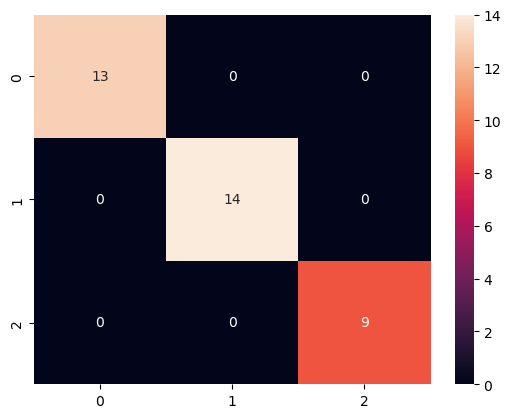

In [135]:
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
parameters = {"n_estimators": [10, 50, 100],
              "bootstrap":[True, False],
              "max_depth":[None, 10, 20,50]}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
Speed_clf_2 = GridSearchCV(RandomForestClassifier(),
                   param_grid=parameters,
                   cv=kf,
                   refit=True,
                   verbose = 1)
Speed_clf_2.fit(X_train,Speed_train)
print("Best parameters: ", Speed_clf_2.best_params_)
print("Best score: ", Speed_clf_2.best_score_)
Speed_pred = Speed_clf_2.predict(X_test)
ac = accuracy_score(Speed_test, Speed_pred)
print('Accuracy is: ',ac)
# recall = recall_score(Speed_test, Speed_pred)
# print('Recall is: ',recall)
# precision = precision_score(Speed_test, Speed_pred)
# print('Precision is: ', precision)
# f1 = f1_score(Speed_test, Speed_pred)
# print('F1 is: ',f1)

cm = confusion_matrix(Speed_test, Speed_pred)
sns.heatmap(cm,annot=True,fmt="d")

We get a flawless confusion matrix

##### We train the model on the whole training dataset, using the parameters uncovered with GridSearch

In [136]:
params = Speed_clf_2.best_params_
# params_save =  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 10}
final_Speed_clf_2= RandomForestClassifier(**params)
final_Speed_clf_2.fit(X,Speed)

RandomForestClassifier(n_estimators=10)

### Final Preprocessing

##### We make a function preprocess 

##### inputs : 
data : the dataset we want to preprocess.
scaler : a scaler that was trained on the training set.
X : the training set ( we use it to compare the columns to avoid having proplems when one speed is missing on the dataset).
id_to_keep : a list of the index of the features that we want to select from the dataset.
speed_missing : indicate if speed is missing from the dataset, in which case it is predicted using the model for speed.
return_speed : indicate if we want the model to return the speed (predicted in case it is missing) separatly from the preprocessed dataset (we need this when we build models for each speed value)

##### outputs :
The preprocessed dataset.
if return_speed is True : we also return the column speed separatly



In [137]:
def preprocess(data, scaler, X, id_to_keep, speed_missing=False, return_speed=False):
    if data.isnull().values.any():
        print('null values detected')
    X_test = data.copy(deep=True)
    if speed_missing :
        X_test['Speed'] = 0
        X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)
        Speed = final_Speed_clf_2.predict(X_test.drop(['Speed'],axis=1))
        Speed_encoded = pd.get_dummies(Speed, drop_first=True)
    else :
        Speed = X_test['Speed']
        Speed_encoded = pd.get_dummies(Speed, drop_first=True)
        X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

    X_test = pd.concat([X_test, Speed_encoded], axis=1)
    X_test = X_test.rename(columns={500:'500', 1000:'1000'})
    missing_cols = set(X.columns) - set(X_test.columns)
    for c in missing_cols:
        X_test[c] = 0
    X_test = X_test[X.columns]
    X_test = X_test.iloc[:, id_to_keep]
    if return_speed :
        return X_test, Speed
    return X_test

# Work package 2

In WP1, you already clean the data, and select the most relevant features. In this work package, the purpose is to develop a machine learning to detect the failed bearing with best performance. 
* Task 1: Design an experiment scheme which evaluates the performance of the developed model based on cross validation.
* Task 2: Develop a model to achieve the best failure detection performance on an individual measurement.
* Task 3: Develop a model to achieve the best failure detection performance on time-series data under variate working conditions.

In this section, you need to present the following (with code and texts to explain):
1. Model selection: Report all the models you have tried on the training dataset and evaluate their performance using cross validation.
2. Data challenge: Apply the best model in the testing dataset:
    * Test bearing 1&2:
        * Explain how do you apply your model to deal with the time-series problem.
        * Apply the model to predict the labels at each time instants.
    * Test bearing 3&4:
        * Explain how do you apply your model to solve the problem of missing the speed measurement.
        * Apply the model to predict the labels at each time instants.
    * Save the results of the predictions in the givne excel file.

In order to analyse the performance of the models developed we made use of the 5-fold cross validation on a basic logistic regression.
Also in order to select the best combination of hyperparameters of each model we used GridSearchCV. By this we were able to conduct the best perfomance of each model.

## Logistic Regression

In [138]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the classifier.
clf_lr = LogisticRegression()
clf_lr = GridSearchCV(LogisticRegression(),
                                  param_grid={'C': [0.1, 10.]},
                                  cv=5,
                                  refit=True)
X_lr = X_backup.copy(deep=True)
X_lr = X_lr.iloc[:, id_to_keep]


In [139]:
# Run a five-fold cross validation.
results = cross_validate(clf_lr, X_lr, y, cv=5, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)
# Define a variable to save the scores of each cross validation run.
cv_scores = {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }
print(cv_scores)


{'Training Accuracy scores': array([0.96527778, 0.92361111, 0.86111111, 0.88194444, 0.84722222]), 'Mean Training Accuracy': 89.58333333333334, 'Training Precision scores': array([1.        , 0.95522388, 0.93333333, 0.95081967, 0.93103448]), 'Mean Training Precision': 0.9540822737640233, 'Training Recall scores': array([0.93055556, 0.88888889, 0.77777778, 0.80555556, 0.75      ]), 'Mean Training Recall': 0.8305555555555555, 'Training F1 scores': array([0.96402878, 0.92086331, 0.84848485, 0.87218045, 0.83076923]), 'Mean Training F1 Score': 0.8872653233425668, 'Validation Accuracy scores': array([0.44444444, 0.97222222, 1.        , 0.91666667, 1.        ]), 'Mean Validation Accuracy': 86.66666666666666, 'Validation Precision scores': array([0.25      , 1.        , 1.        , 0.94117647, 1.        ]), 'Mean Validation Precision': 0.8382352941176471, 'Validation Recall scores': array([0.05555556, 0.94444444, 1.        , 0.88888889, 1.        ]), 'Mean Validation Recall': 0.7777777777777778

## Support Vector Classifier

In [140]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.svm import SVC

parameters_svm = {"C": [0.1, 1, 10],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "degree": [2, 3, 4],
              "gamma": ['scale', 'auto']}

clf_svm = GridSearchCV(SVC(),
                   param_grid=parameters_svm,
                   cv=5,
                   refit=True,
                   verbose=1)
X_svm = X_backup.copy(deep=True)
X_svm = X_svm.iloc[:, id_to_keep]

In [141]:
results = cross_validate(clf_svm, X_svm, y, cv=5, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)
cv_scores = {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }
print(cv_scores)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'Training Accuracy scores': array([0.97916667, 0.86111111, 0.77083333, 0.78472222, 0.82638889]), 'Mean Training Accuracy': 84.44444444444444, 'Training Precision scores': array([1.        , 1.        , 0.97560976, 1.        , 1.        ]), 'Mean Training Precision': 0.9951219512195122, 'Training Recall scores': array([0.95833333, 0.72222222, 0.55555556, 0.56944444, 0.65277778]), 'Mean Training Recall': 0.6916666666666667, 'Training F1 scores': array([0.9787234 , 0.83870968, 0.7079646 , 0.72566372, 0.78991597]), 'Mean Training F1 Score': 0.8081954733290599, 'Validation Accuracy scores': array([0.44444444, 0.66666667, 1.        , 0.91666667, 1.        ]), 'Mean Validation Accuracy':

## *Normal* Random Forest Classifier

### Training phase

We define the model using GridSeatch on a dictionnary of parameters (same dictionnary used to train the speed model)
We train it on 80% of the training dataset
We use the remaining data to evaluate the performance using a the confustion matrix

In [142]:
clf = GridSearchCV(RandomForestClassifier(),
                   param_grid=parameters,
                   cv=kf,
                   refit=True,
                   verbose = 1)
X = X_backup.copy(deep=True)
X = X.iloc[:, id_to_keep]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train,y_train)
print("Best parameters: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'bootstrap': False, 'max_depth': 50, 'n_estimators': 10}
Best score:  1.0


accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0


<Axes: >

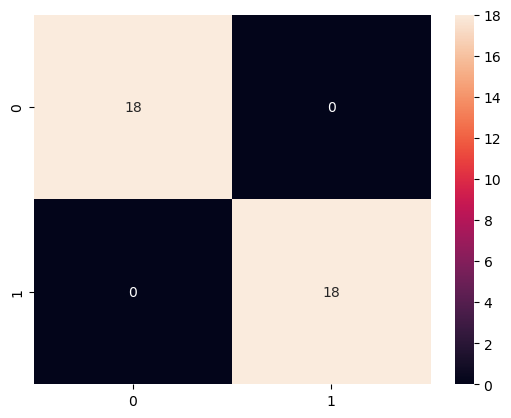

In [143]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("accuracy :", accuracy)
print("precision :", precision)
print("recall :", recall)
print("f1 :", f1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d")


Most of the time (depending on the random split), the confusion matrix is flawless, or there are at most 2 missclassifications

Using the uncovered parameters from GridSearch, we train a final model on all the training dataset, this one we be used to predict the labels from the testing excel file

In [144]:
params = clf.best_params_
params_save =  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 10}
clf_final = RandomForestClassifier(**params_save)
results = cross_validate(clf_final, X, y, cv=5, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)
cv_scores = {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
             }
print(cv_scores)
clf_final.fit(X,y)

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]), 'Mean Training Accuracy': 100.0, 'Training Precision scores': array([1., 1., 1., 1., 1.]), 'Mean Training Precision': 1.0, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([1., 1., 1., 1., 1.]), 'Mean Training F1 Score': 1.0, 'Validation Accuracy scores': array([0.72222222, 0.91666667, 1.        , 0.94444444, 0.97222222]), 'Mean Validation Accuracy': 91.11111111111111, 'Validation Precision scores': array([0.78571429, 1.        , 1.        , 0.9       , 1.        ]), 'Mean Validation Precision': 0.937142857142857, 'Validation Recall scores': array([0.61111111, 0.83333333, 1.        , 1.        , 0.94444444]), 'Mean Validation Recall': 0.8777777777777779, 'Validation F1 scores': array([0.6875    , 0.90909091, 1.        , 0.94736842, 0.97142857]), 'Mean Validation F1 Score': 0.9030775803144225}


RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=10)

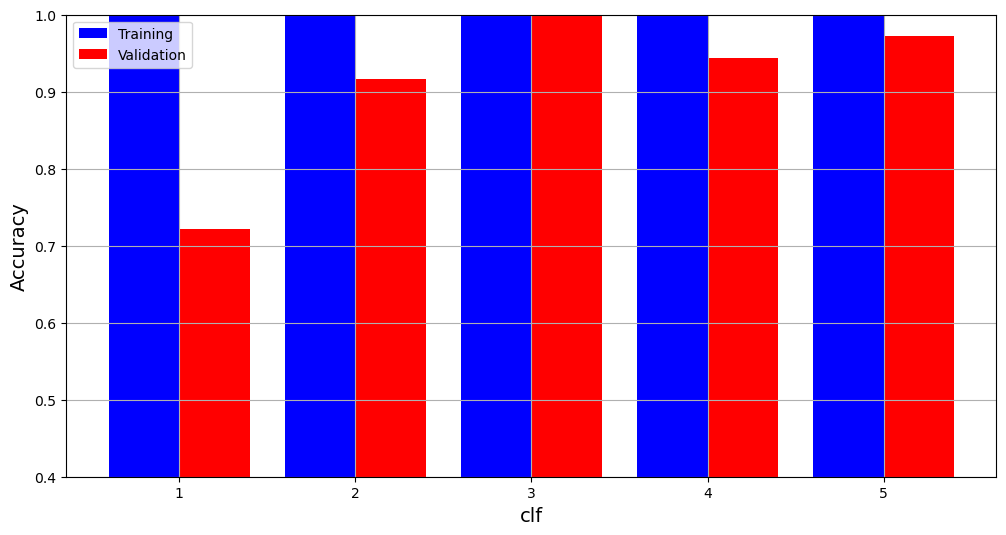

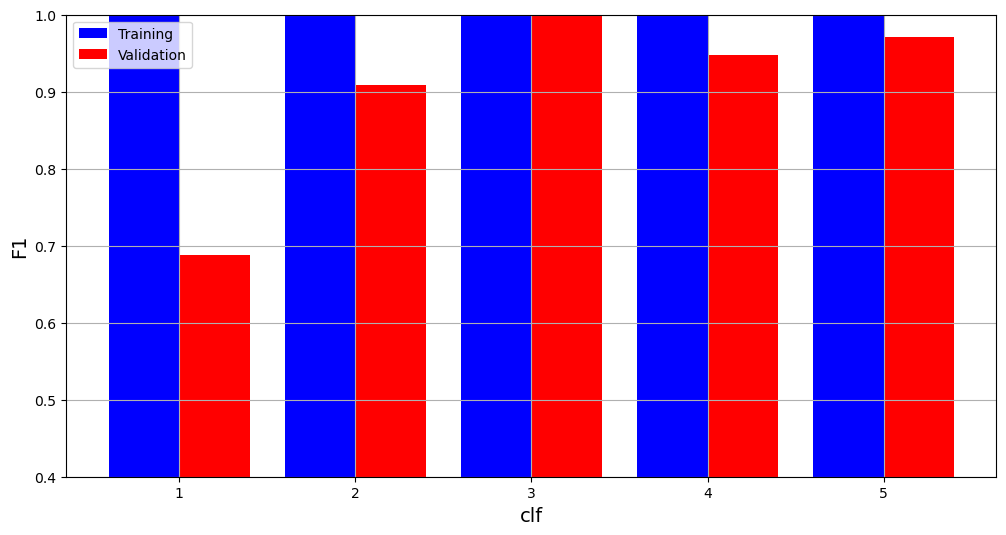

In [145]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = np.arange(len(train_data))+1
        X_axis = np.arange(len(train_data))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()


plot_result('clf',
            "Accuracy",
            "Accuracy scores in 5 Folds",
            cv_scores["Training Accuracy scores"],
            cv_scores["Validation Accuracy scores"])

plot_result('clf',
            "F1",
            "F1 scores in 5 Folds",
            cv_scores["Training F1 scores"],
            cv_scores["Validation F1 scores"])

### Testing Phase

we first need to define a function to read the testing excel file, this function will be also used on all the other models (with some modifications)
In this cell, we can rapidly switch between testing page 1 and 2 excel file.

In [146]:
def read_test_data(page):
    filename = 'Testing.xlsx'
    df = pd.read_excel(filename, sheet_name=page, usecols='A:M', header=0, nrows=20)
    return df

df_test_1 = read_test_data(1)
X_test_1 = preprocess(df_test_1, scaler, X_backup, id_to_keep)
X_test_1
clf_final.predict(X_test_1)


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

to make things more convenient, we test page 3 and 4 on this cell, so that we don't have to change speed_missing parameter.
We can also test page 1 and 2 on this cell, this will ignore the already provided speed and predict it.

In [147]:
df_test_2 = read_test_data(1)
X_test_2 = preprocess(df_test_2, scaler, X_backup, id_to_keep, speed_missing=True)
clf_final.predict(X_test_2)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

## Random Forest Classifier inluding data from past time stamp


### First Step :
we recover X from the backup as we may have changed it, we also define the features to use from past time stamp :
we decide to only keep the averages and the speed from the past time stamp

In [148]:
X = X_backup.copy(deep=True)
X = X.iloc[:, id_to_keep]
X_shifted = X_backup.copy(deep=True)
shifted_id = [1,4,7,10,13,14]
X_shifted = X_shifted.iloc[:,shifted_id]

### Creating the new training set

in this cell, we create a function shift that shifts a dataset, and replace the first row (which is now empty) with the old first row.

Example : [1,2,3,4,5] is shifted into [1,1,2,3,4]

In [149]:
def shift_df(df):
    df_copy = df.copy(deep=True)
    df_shifted = df_copy.shift(1)
    df_shifted.iloc[0] = df_copy.iloc[0]
    return df_shifted

for speed in [100, 500, 1000]:
    for label in [0, 1]:    
        x = X_shifted.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed)]
        x = shift_df(x)
        X_shifted.loc[(df_data_org['Label']==label) & (df_data_org['Speed']==speed)] = x

X_shifted.columns = [col + '_t-1' for col in X_shifted.columns]

the we produce our new dataset using concatenation

In [150]:
X_final = pd.concat([X, X_shifted], axis=1)
X_final.head(10)

,VIB1: aRMS min,VIB1: aRMS avg,VIB1: aRMS max,VIB1: vRMS min,VIB1: vRMS avg,VIB1: vRMS max,VIB1: DKW min,VIB1: DKW avg,VIB1: DKW max,VIB1: aPeak min,VIB1: aPeak avg,VIB1: aPeak max,500,1000,VIB1: aRMS avg_t-1,VIB1: vRMS avg_t-1,VIB1: DKW avg_t-1,VIB1: aPeak avg_t-1,500_t-1,1000_t-1
0,-0.789312,-0.825551,-0.804636,-0.527634,-0.536658,-0.526689,-0.636545,-0.697604,-0.651478,-0.869620,-0.974956,-0.981062,0,0,-0.825551,-0.536658,-0.697604,-0.974956,0,0
1,-0.792483,-0.821033,-0.806857,-0.531264,-0.516094,-0.408313,-0.636576,-0.697501,-0.651386,-0.869888,-0.971297,-0.976368,0,0,-0.825551,-0.536658,-0.697604,-0.974956,0,0
2,-0.791877,-0.820844,-0.807280,-0.532455,-0.531674,-0.421275,-0.636550,-0.697501,-0.651414,-0.869304,-0.971317,-0.977607,0,0,-0.821033,-0.516094,-0.697501,-0.971297,0,0
3,-0.791374,-0.820081,-0.806546,-0.532295,-0.541076,-0.573326,-0.636570,-0.697502,-0.651436,-0.869866,-0.971445,-0.978826,0,0,-0.820844,-0.531674,-0.697501,-0.971317,0,0
4,-0.790518,-0.819402,-0.806066,-0.533190,-0.535770,-0.521887,-0.636574,-0.697481,-0.651095,-0.870005,-0.970836,-0.963326,0,0,-0.820081,-0.541076,-0.697502,-0.971445,0,0
5,-0.790211,-0.818870,-0.805930,-0.532972,-0.541471,-0.573879,-0.636615,-0.697493,-0.651379,-0.871336,-0.971332,-0.976414,0,0,-0.819402,-0.535770,-0.697481,-0.970836,0,0
6,-0.788549,-0.818193,-0.805346,-0.533541,-0.542081,-0.572717,-0.636615,-0.697472,-0.651347,-0.871336,-0.970700,-0.975059,0,0,-0.818870,-0.541471,-0.697493,-0.971332,0,0
7,-0.788463,-0.818061,-0.804957,-0.534125,-0.541964,-0.573106,-0.636586,-0.697437,-0.650593,-0.870597,-0.969540,-0.941060,0,0,-0.818193,-0.542081,-0.697472,-0.970700,0,0
8,-0.787030,-0.815850,-0.800076,-0.532567,-0.541210,-0.573572,-0.636494,-0.696800,-0.647983,-0.868377,-0.949303,-0.836000,0,0,-0.818061,-0.541964,-0.697437,-0.969540,0,0
9,-0.787023,-0.813785,-0.797799,-0.533208,-0.511629,-0.526689,-0.636517,-0.695576,-0.647928,-0.868831,-0.911175,-0.841095,0,0,-0.815850,-0.541210,-0.696800,-0.949303,0,0


### Training Phase :
We proceed similarly to the training done for the normal random forest :
training on using grid search on 80% of the training dataset, then training using the whole training dataset and the best parameters from grid_search


In [151]:
clf_shift = GridSearchCV(RandomForestClassifier(),
                   param_grid=parameters,
                   cv=kf,
                   refit=True,
                   verbose = 1)

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)
clf_shift.fit(X_train,y_train)
print("Best parameters: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'bootstrap': False, 'max_depth': 50, 'n_estimators': 10}
Best score:  1.0


accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0


<Axes: >

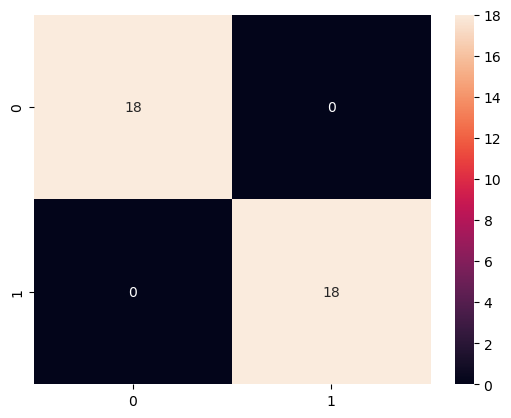

In [152]:
y_pred = clf_shift.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("accuracy :", accuracy)
print("precision :", precision)
print("recall :", recall)
print("f1 :", f1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d")

In [153]:
params_shift = clf_shift.best_params_
# params_save =  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 10}
clf_shift_final = RandomForestClassifier(**params_shift)
clf_shift_final.fit(X_final,y)

RandomForestClassifier()

### Testing Phase

We fist make a fucntion that return the test dataset in the required format, then we test our model

In [154]:
def preprocess_shifted(df, scaler, X_backup, id_to_keep, shifted_id, speed_missing = False):
    X1 = preprocess(df, scaler, X_backup, id_to_keep, speed_missing = speed_missing)
    X1_shifted = preprocess(df, scaler, X_backup, shifted_id, speed_missing = speed_missing)
    X1_shifted = shift_df(X1_shifted)
    X1_shifted.columns = [col + '_t-1' for col in X1_shifted.columns]
    X1_final = pd.concat([X1, X1_shifted], axis=1)
    return X1_final

df_test_1 = read_test_data(1)
X_test_shifted_1 = preprocess_shifted(df_test_1, scaler,X_backup, id_to_keep, shifted_id, False)
clf_shift_final.predict(X_test_shifted_1)


array([1, 1, 0, 0, 0, 0, 1, 1, 0, 0], dtype=int64)

In [155]:
df_test_2 = read_test_data(3)
X_test_shifted_2 = preprocess_shifted(df_test_2, scaler,X_backup,id_to_keep, shifted_id, True)
clf_shift_final.predict(X_test_shifted_2)

null values detected
null values detected


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

## A model for Each Speed

### First Step :
recovering X from the backup, defining a list of speeds (for convenience), and choosing the features to use in the model.
we only use the average of each sensor

In [156]:
X = X_backup.copy(deep=True)
id_to_keep1 = [1,4,7,10]
X = X.iloc[:,id_to_keep1]
speeds = [100,500,1000]

### Preparing the training dataset :

Two dictionnaries, X_dict, and y_dict.
in X_dict, we associate each speed value with a the training dataset that only has this speed.
We do the same for y_dict.
Since the original dataset is well indexed, we can make sure that each smaller X dataset matches well the smaller y

In [157]:
X_dict={}
y_dict = {}
for speed in speeds:
    X_dict[speed] = X.loc[(df_data_org['Speed']==speed)].copy(deep=True)
    y_dict[speed] = y.loc[(df_data_org['Speed']==speed)].copy(deep=True)


In this cell, we verify that we split well the data into the 3 smaller dataset that each corresponds to one speed value

In [158]:
ind = 100
print(X_dict[ind].shape)
X_dict[ind].head(10)

(60, 4)


,VIB1: aRMS avg,VIB1: vRMS avg,VIB1: DKW avg,VIB1: aPeak avg
0,-0.825551,-0.536658,-0.697604,-0.974956
1,-0.821033,-0.516094,-0.697501,-0.971297
2,-0.820844,-0.531674,-0.697501,-0.971317
3,-0.820081,-0.541076,-0.697502,-0.971445
4,-0.819402,-0.535770,-0.697481,-0.970836
5,-0.818870,-0.541471,-0.697493,-0.971332
6,-0.818193,-0.542081,-0.697472,-0.970700
7,-0.818061,-0.541964,-0.697437,-0.969540
8,-0.815850,-0.541210,-0.696800,-0.949303
9,-0.813785,-0.511629,-0.695576,-0.911175


### Model buildind and Training Phase

We make a dictionnary clf_dict that associates each speed value to its corresponding model, and we train each model proceding in the same way as before

In [159]:
clf_dict = {}
X_train_dict, X_test_dict, y_train_dict, y_test_dict = {},{},{},{}

for speed in speeds:
    clf_dict[speed]= GridSearchCV(RandomForestClassifier(),
                    param_grid=parameters,
                    cv=kf,
                    refit=True,
                    verbose = 0)

    X_train_dict[speed], X_test_dict[speed], y_train_dict[speed], y_test_dict[speed] = train_test_split(X_dict[speed], y_dict[speed], test_size=0.2, random_state=42)
    clf_dict[speed].fit(X_train_dict[speed],y_train_dict[speed])
    print('speed ',speed, 'model')
    print("Best parameters: ", clf.best_params_)
    print("Best score: ", clf.best_score_)
    print('#################')

speed  100 model
Best parameters:  {'bootstrap': False, 'max_depth': 50, 'n_estimators': 10}
Best score:  1.0
#################
speed  500 model
Best parameters:  {'bootstrap': False, 'max_depth': 50, 'n_estimators': 10}
Best score:  1.0
#################
speed  1000 model
Best parameters:  {'bootstrap': False, 'max_depth': 50, 'n_estimators': 10}
Best score:  1.0
#################


Speed 100 model
accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
###########################
Speed 500 model
accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
###########################
Speed 1000 model
accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
###########################


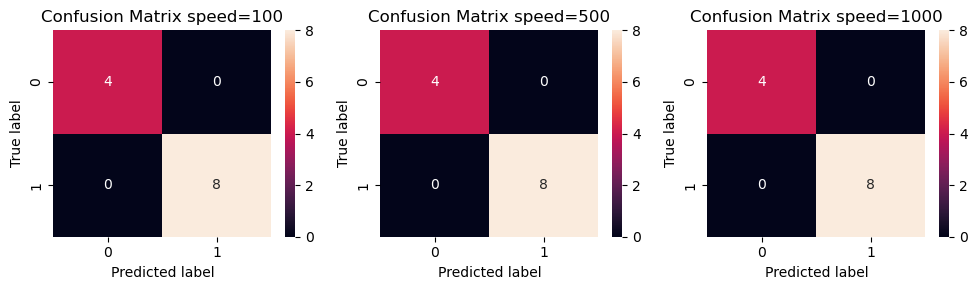

In [160]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

matrices=[]
for speed in speeds:
    print('Speed', speed, 'model')
    y_pred = clf_dict[speed].predict(X_test_dict[speed])
    accuracy = accuracy_score(y_test_dict[speed], y_pred)
    precision = precision_score(y_test_dict[speed], y_pred, average='macro')
    recall = recall_score(y_test_dict[speed], y_pred, average='macro')
    f1 = f1_score(y_test_dict[speed], y_pred, average='macro')
    print("accuracy :", accuracy)
    print("precision :", precision)
    print("recall :", recall)
    print("f1 :", f1)
    cm = confusion_matrix(y_test_dict[speed], y_pred)
    matrices.append(cm)
    print('###########################')

for i, ax in enumerate(axes.flat):
    if i==3 :
        break
    sns.heatmap(matrices[i], annot=True, fmt='d', ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'Confusion Matrix speed={speeds[i]}')

plt.tight_layout()
plt.show()

The results on the validation set are very promising! considering that we only use 4 features ( 5 if we count also the speed)

In [161]:
clf_dict_final = {}
for speed in speeds :  
    params = clf_dict[speed].best_params_
    # params_save =  {'bootstrap': False, 'max_depth': 10, 'n_estimators': 10}
    clf_dict_final[speed] = RandomForestClassifier(**params_shift)
    clf_dict_final[speed].fit(X_dict[speed],y_dict[speed])

### Testing Phase

this time, we can't just feed the testing set to the model
we need to define a custom function for the prediction

The function takes as an input : X the set we want to predict, Speed, a list that indicates for each row in X what is the speed (so we can choose the corresponding model) and clf_dict, which is our trained model.

the function predicts each row separatrly in X using its speed and the corresponding model


In [162]:
def predict(X, Speed, clf_dict):
    n = len(X)
    prediction = [-1]*n
    for i in range(n):
        x = X.loc[[i]]
        speed = Speed[i]
        pred = clf_dict[speed].predict(x)
        prediction[i] = pred[0]
    return prediction


df_test_1 = read_test_data(1)
X_test_1, Speed_test_1 = preprocess(df_test_1, scaler, X_backup, id_to_keep1, return_speed = True)
# X_test_1 = X_test_1.drop(['500','1000'], axis=1)
# Speed_test_1 = df_test_1['Speed']
predict(X_test_1, Speed_test_1, clf_dict_final)
# X_test_1.loc[[0]]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

In [163]:
df_test_2 = read_test_data(0)
X_test_2, Speed_test_2 = preprocess(df_test_2, scaler,X_backup,id_to_keep1, speed_missing=True, return_speed = True)
# X_test_2 = X_test_2.drop(['500','1000'], axis=1)
# Speed_test_1 = df_test_1['Speed']
predict(X_test_2, Speed_test_2, clf_dict_final)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]